
# 10. (Appendix) End-to-End Experimentation

In the world of **super agents** — autonomous, learning systems that plan, act, and adapt through continuous feedback — **experimentation** is the bridge between *reasoning* and *learning*.  It’s how an agent decides *what works*, *for whom*, and *under what circumstances*.

## 🧠 What is Experimentation?

At its core, **experimentation** is the *empirical process of intervention and observation* designed to infer **causal effects** — not just correlations. It allows an agent (or system) to answer counterfactual questions like:

> *“If I changed my policy, recommendation, or message — how would user behavior differ?”*

In formal terms, experimentation is the operational realization of **causal inference**.  It seeks to estimate the **Average Treatment Effect (ATE)**:
$$\text{ATE} = \mathbb{E}[Y(1) - Y(0)]$$
where \(Y(1)\) and \(Y(0)\) are potential outcomes under treatment and control.

## 🤖 Why It Matters for Super Agents

Super agents continuously optimize decisions — from dynamic pricing and content ranking to adaptive UX, incentive design, or marketing personalization.  
Without controlled experimentation, these systems risk **learning from confounded or biased data**, leading to:

- **Spurious correlations** mistaken for causal mechanisms  
- **Reward hacking** (optimizing proxies, not true outcomes)  
- **Feedback loops** that amplify errors or unfairness  

Through structured experimentation, agents can **safely explore**, **evaluate interventions**, and **update causal models** in production — closing the loop between perception, reasoning, and learning.

Key goals:
- Discover **what causes improvement**, not just what co-occurs  
- Quantify **heterogeneous treatment effects (CATE)** — who benefits most  
- Integrate **causal reasoning** into **reinforcement learning** and **multi-agent coordination**  
- Ensure decisions are **robust, fair, and explainable**


## 🧩 Experimentation in the Era of Agentic AI

As **agentic systems** (multi-agent swarms, LLM-based orchestrators, reinforcement learners) scale into dynamic environments, **causal experimentation** becomes their north star.  
Super agents must not only act optimally but also **question their own policies**:

- *“Did my new message cause retention to improve, or did I just target loyal users?”*  
- *“Did my bonus scheme genuinely reduce churn, or merely delay it?”*  
- *“What causal graph best explains observed behavior?”*

By embedding experimentation primitives — A/B testing, counterfactual reasoning, and do-calculus — into their architecture, super agents evolve beyond reactive prediction into **self-reflective, causal learners**.

**In short:**  Experimentation is how *super agents learn causation, not correlation* —> the foundation of reliable intelligence, safe autonomy, and scientific reasoning.

> Note: True “Causal Forests” are implemented in packages like `econml` or `grf`. Here we implement **meta‑learner** approaches with `sklearn` Random Forests which deliver forest‑style **nonlinear CATE** approximations that work well in practice and are easy to run anywhere.


## 🧪 Understanding the Synthetic Experimentation Setup

Before we run A/B tests or causal estimations, we need a **sandbox world** where we know the *true data-generating process (DGP)* — what actually causes what. This code simulates such a world: a population of 50,000 synthetic users, each with traits, behaviors, and decisions that influence whether they receive a treatment (like an offer, message, or recommendation) and what outcome they produce.

This kind of simulation helps us **teach super agents to reason about causality** — not just pattern-match correlations.


### 🧭 Key Concepts and Symbols

| Symbol / Variable | Role | Meaning | Why It Matters |
|--------------------|------|----------|----------------|
| **X = {age, activity_score, segment}** | **Observed confounders** | Factors that affect **both** the treatment and the outcome. | If you don’t adjust for them, you’ll mistake correlation for causation. |
| **U (u_latent)** | **Unobserved confounder** | Hidden variable (like “innate engagement” or “loyalty”) that also influences both treatment and outcome. | Biases naïve analyses because you can’t directly control for it. |
| **Z** | **Instrument (randomized encouragement)** | A *random* signal (like a notification or ad exposure) that nudges users toward treatment but has **no direct effect** on the outcome except through that treatment. | Lets us recover the true causal effect even when treatment isn’t fully random. |
| **E (eligibility)** | **Exposure opportunity** | Whether a user was eligible to even receive treatment (e.g., enough activity to qualify). | Creates **exposure bias** — active users are both more likely to see treatment and perform better. |
| **T (treatment)** | **Action or intervention** | Whether the user actually received the treatment (e.g., personalized bonus, new UX flow). | The variable whose causal effect we want to measure. |
| **exposure (mediator)** | **Dose / mediator** | How much of the treatment a user actually experiences (e.g., number of times they saw the campaign). | Lies *between* treatment and outcome — helps separate direct and indirect effects. |
| **C (collider)** | **Do NOT control** | Variable caused by both treatment and a confounder (e.g., “visited the experiment page”). | Conditioning on it **creates spurious correlations** — a common causal mistake. |
| **Y (outcome)** | **Response / metric** | The final performance metric (e.g., revenue, retention, satisfaction). | What we ultimately care about improving. |


### 🔄 The Causal Logic Behind the Simulation

The relationships can be visualized as a **causal graph (DAG):**

      Z ─────► T ─────► exposure ─────► Y
                 ▲          ▲
                 │          │
       U (latent)│          │
                 │          │
                 ▼          ▼
                 Y        E (eligibility)


- `Z` is randomized, so it’s **independent of confounders** — a good *instrument*.  
- `U` affects both `T` and `Y`, creating **confounding bias** if we ignore it.  
- `E` drives exposure bias — eligible users tend to both get treated and perform better.  
- `exposure` mediates part of the treatment effect — higher exposure means stronger influence.  
- `C` is a **collider**: caused by `T` and `U`; controlling for it would *open* a spurious path and distort results.


### 🧩 Why This Matters for Super Agents

In a **super agent ecosystem** (think of a self-improving AI orchestrating marketing, recommendations, or policies):

- The **agent’s actions** are treatments (`T`).  
- The **world’s feedback** is the outcome (`Y`).  
- **Context** (user traits, history) forms the confounders (`X`, `U`).  
- **Eligibility / exposure** are the real-world constraints that create bias.  
- And **randomized interventions (`Z`)** — whether deliberate A/B tests or exploratory actions — are how the agent *learns* the true causal impact of its behavior.

Without recognizing these roles, a super agent might:
- Over-credit its actions for outcomes it didn’t cause,
- Reinforce bias loops (e.g., show bonuses only to high-activity users),
- Fail to generalize when deployed in new contexts.


### 🧠 Why Check the “First-Stage” (F-Statistic)?

After simulating the data, we estimate  
$$T_i = \alpha + \pi Z_i + \gamma X_i + \epsilon_i$$
to verify that the **instrument Z actually influences the treatment T**.

A strong F-statistic (above ~10) means the instrument is *relevant* — it meaningfully shifts treatment probability. In our run, we got **F ≈ 3780**, confirming Z is an excellent instrument.

In short, this is how **super agents learn to experiment like scientists** — by modeling cause and effect, not just prediction.


In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import OneHotEncoder

rng = np.random.default_rng(123)

# 1) Users & observed confounders X
N = 50_000
signup_month = rng.integers(1, 7, size=N)
segment = rng.choice(["casual", "regular", "vip"], size=N, p=[0.5, 0.4, 0.1])
age = rng.normal(35, 10, size=N).clip(18, 75)
activity_score = rng.gamma(shape=2.0, scale=2.0, size=N)

# Unobserved confounder U (not observable in analysis)
u_latent = rng.normal(0, 1, size=N)

# Pre-period baseline (CUPED covariate)
pre_metric = 5 + 0.25*activity_score + 0.02*(age-35) + 0.8*u_latent + rng.normal(0, 1.0, N)

# 2) Instrument Z: randomized encouragement (valid IV if exclusion holds)
Z = rng.binomial(1, 0.5, size=N)

# 3) Eligibility E: exposure opportunity (drives exposure bias if ignored)
logit_E = -0.5 + 0.3*(activity_score - activity_score.mean())/activity_score.std()
p_E = 1/(1+np.exp(-logit_E))
E = rng.binomial(1, p_E, size=N)

# 4) Treatment T: NOT randomized (affected by Z, U, and E)
logit_T = -0.4 + 1.2*Z + 0.6*u_latent + 0.5*E + 0.15*(activity_score > 2.5)
p_T = 1/(1+np.exp(-logit_T))
T = rng.binomial(1, p_T, size=N)

# 5) Mediator / Exposure: dose of treatment actually received
lambda_exposure = 0.3 + 1.2*T + 0.35*activity_score + 0.8*E
exposure = rng.poisson(lam=np.maximum(lambda_exposure, 0.05))

# 6) Collider C (do NOT control for it in analysis)
logit_C = -0.2 + 1.0*T + 0.8*u_latent
p_C = 1/(1+np.exp(-logit_C))
C = rng.binomial(1, p_C, size=N)

# 7) Outcome Y (structural DGP)
tau = 1.2        # true treatment effect
beta_exp = 0.15  # mediator effect
theta_u = 1.0    # unobserved confounding into Y
theta_cov = 0.02
theta_seg = {"casual": 0.0, "regular": 0.4, "vip": 1.0}
seg_eff = np.array([theta_seg[s] for s in segment])

Y = (
    2.0
    + tau*T
    + beta_exp*exposure
    + theta_cov*(age - 35)
    + 0.3*activity_score
    + seg_eff
    + theta_u*u_latent
    + rng.normal(0, 1.0, N)
)

df = pd.DataFrame({
    "signup_month": signup_month,
    "segment": segment,
    "age": age,
    "activity_score": activity_score,
    "pre_metric": pre_metric,
    "Z": Z,           # instrument
    "E": E,           # eligibility (exposure opportunity)
    "T": T,           # treatment
    "exposure": exposure,  # mediator / dose
    "C": C,           # collider (avoid conditioning)
    "Y": Y
})

# --- Quick diagnostics ---
# First-stage relevance for IV: T ~ Z + X
enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
seg_oh = enc.fit_transform(df[["segment"]])
seg_cols = [f"segment_{c}" for c in enc.categories_[0][1:]]
X1 = pd.DataFrame(seg_oh, columns=seg_cols)
X1["age"] = df["age"].values
X1["activity_score"] = df["activity_score"].values
X1["E"] = df["E"].values
X1["Z"] = df["Z"].values
stage1 = OLS(df["T"], add_constant(X1)).fit()
F_Z = float(stage1.tvalues["Z"]**2)  # quick proxy; strong if >10
print(f"First-stage relevance (approx F for Z): {F_Z:.2f}")

# Simple correlation sanity check (instrument should not be strongly tied to Y except via T)
print(df[["Z","T","E","exposure","Y"]].corr(numeric_only=True).round(3))

df.head()

First-stage relevance (approx F for Z): 3779.99
              Z      T      E  exposure      Y
Z         1.000  0.263 -0.005     0.075  0.093
T         0.263  1.000  0.099     0.314  0.479
E        -0.005  0.099  1.000     0.281  0.138
exposure  0.075  0.314  0.281     1.000  0.496
Y         0.093  0.479  0.138     0.496  1.000


,signup_month,segment,age,activity_score,pre_metric,Z,E,T,exposure,C,Y
0,1,casual,22.711829,1.669579,5.376245,1,1,0,5,0,3.008113
1,5,regular,22.617197,1.933272,6.584379,1,0,1,4,1,4.714501
2,4,casual,41.929186,8.127488,8.306504,1,1,1,7,1,8.429949
3,1,casual,31.294262,2.833979,7.671104,1,0,0,0,1,3.139591
4,6,casual,29.375951,1.999539,2.347816,0,1,1,1,0,1.490900


### 🔍 First-stage relevance

```
First-stage relevance (approx F for Z): 3779.99
```

* This is **very strong**.

  * Rule of thumb: F > 10 means your instrument has strong predictive power for the treatment (Z → T).
  * Here, F ≈ 3800 indicates the **instrument is highly relevant**, so 2SLS will not suffer from weak-instrument bias.


### 📊 Correlation matrix interpretation

| Variable              | Notes                     | What we expect    | Interpretation                                                       |
| --------------------- | ------------------------- | ----------------- | -------------------------------------------------------------------- |
| **Z–T = 0.26**        | instrument–treatment link | moderate positive | ✅ Z influences T as designed (relevance).                            |
| **Z–Y = 0.09**        | instrument–outcome        | low               | ✅ Good. Z affects Y *mostly through* T (exclusion roughly holds).    |
| **E–T = 0.10**        | eligibility–treatment     | weak–moderate     | ✅ Eligibility increases chance of treatment.                         |
| **E–exposure = 0.28** | eligibility–exposure      | moderate          | ✅ Eligibility boosts exposure opportunities (the bias mechanism).    |
| **T–Y = 0.48**        | treatment–outcome         | strong            | ✅ The causal + confounded relationship.                              |
| **exposure–Y = 0.50** | exposure–outcome          | strong            | ✅ Exposure acts as a mediator/dose with its own causal contribution. |


### ⚖️ Quick sanity checklist

| Causal role                                  | Check                                 | Status                  |
| -------------------------------------------- | ------------------------------------- | ----------------------- |
| Instrument relevance (Z→T)                   | F > 10                                | ✅ Strong                |
| Instrument exogeneity (Z↛Y directly)         | Z–Y corr small (~0.09)                | ✅ Reasonable            |
| Confounding (U, E) creates bias in naive OLS | E correlated with both exposure and Y | ✅ Correct               |
| Exposure mediates part of treatment effect   | exposure–Y corr = 0.50                | ✅ Strong mediation path |


### 🧠 Summary

✔️ **Z is a strong, valid instrument candidate.**
✔️ **Exposure behaves as a mediator** and **eligibility as a source of bias**.
✔️ **Outcome structure matches theoretical expectations.**
✔️ **No signs of design error or unintentional over-correlation.**

## 📊 Cohort Creation for Experimental Analysis

Cohorts help us **compare like with like** — ensuring fair evaluation and understanding of how effects differ across groups.  

In real experimentation (and for agentic systems), cohorts allow:
- Checking **randomization balance** (is treatment evenly distributed across user types?),
- Understanding **heterogeneous effects** (do VIPs react differently than casual users?),
- Detecting **drift** (how user mix evolves over time).

We'll build cohorts along key dimensions:
- **User segment** (`casual`, `regular`, `vip`)  
- **Signup month** (temporal cohort)
- **Activity level bins** (based on engagement score)
- **Age groups**

Then, we’ll compute:
- Average pre-period metric (`pre_metric`)
- Treatment rate (`T`)
- Average outcome (`Y`)
- Exposure intensity (`exposure`)

In [6]:
import warnings

warnings.simplefilter('ignore')

# Define activity and age bins for interpretable cohorts
df["activity_bin"] = pd.qcut(df["activity_score"], q=4, labels=["low", "mid-low", "mid-high", "high"])
df["age_bin"] = pd.cut(df["age"], bins=[17, 25, 35, 45, 60, 100], labels=["<25", "25-35", "35-45", "45-60", "60+"])

# Build cohort table by segment, activity, and signup month
cohort_summary = (
    df.groupby(["segment", "activity_bin", "signup_month"])
      .agg(
          n_users=("Y", "size"),
          avg_pre_metric=("pre_metric", "mean"),
          treat_rate=("T", "mean"),
          avg_exposure=("exposure", "mean"),
          avg_outcome=("Y", "mean")
      )
      .reset_index()
      .sort_values(["segment", "activity_bin", "signup_month"])
)

display(cohort_summary.head(20))

,segment,activity_bin,signup_month,n_users,avg_pre_metric,treat_rate,avg_exposure,avg_outcome
0,casual,low,1,1093,5.297909,0.574565,1.649588,3.326839
1,casual,low,2,984,5.321728,0.577236,1.684959,3.332103
2,casual,low,3,1013,5.281374,0.584403,1.751234,3.360727
3,casual,low,4,1061,5.269390,0.546654,1.637135,3.184691
4,casual,low,5,1009,5.268901,0.579782,1.627354,3.292858
5,casual,low,6,1073,5.300322,0.567568,1.568500,3.227041
6,casual,mid-low,1,1060,5.672900,0.578302,2.213208,3.834305
7,casual,mid-low,2,1034,5.732641,0.608317,2.236944,3.867057
8,casual,mid-low,3,1011,5.686038,0.594461,2.223541,3.818538
9,casual,mid-low,4,1042,5.684384,0.600768,2.342610,3.939398


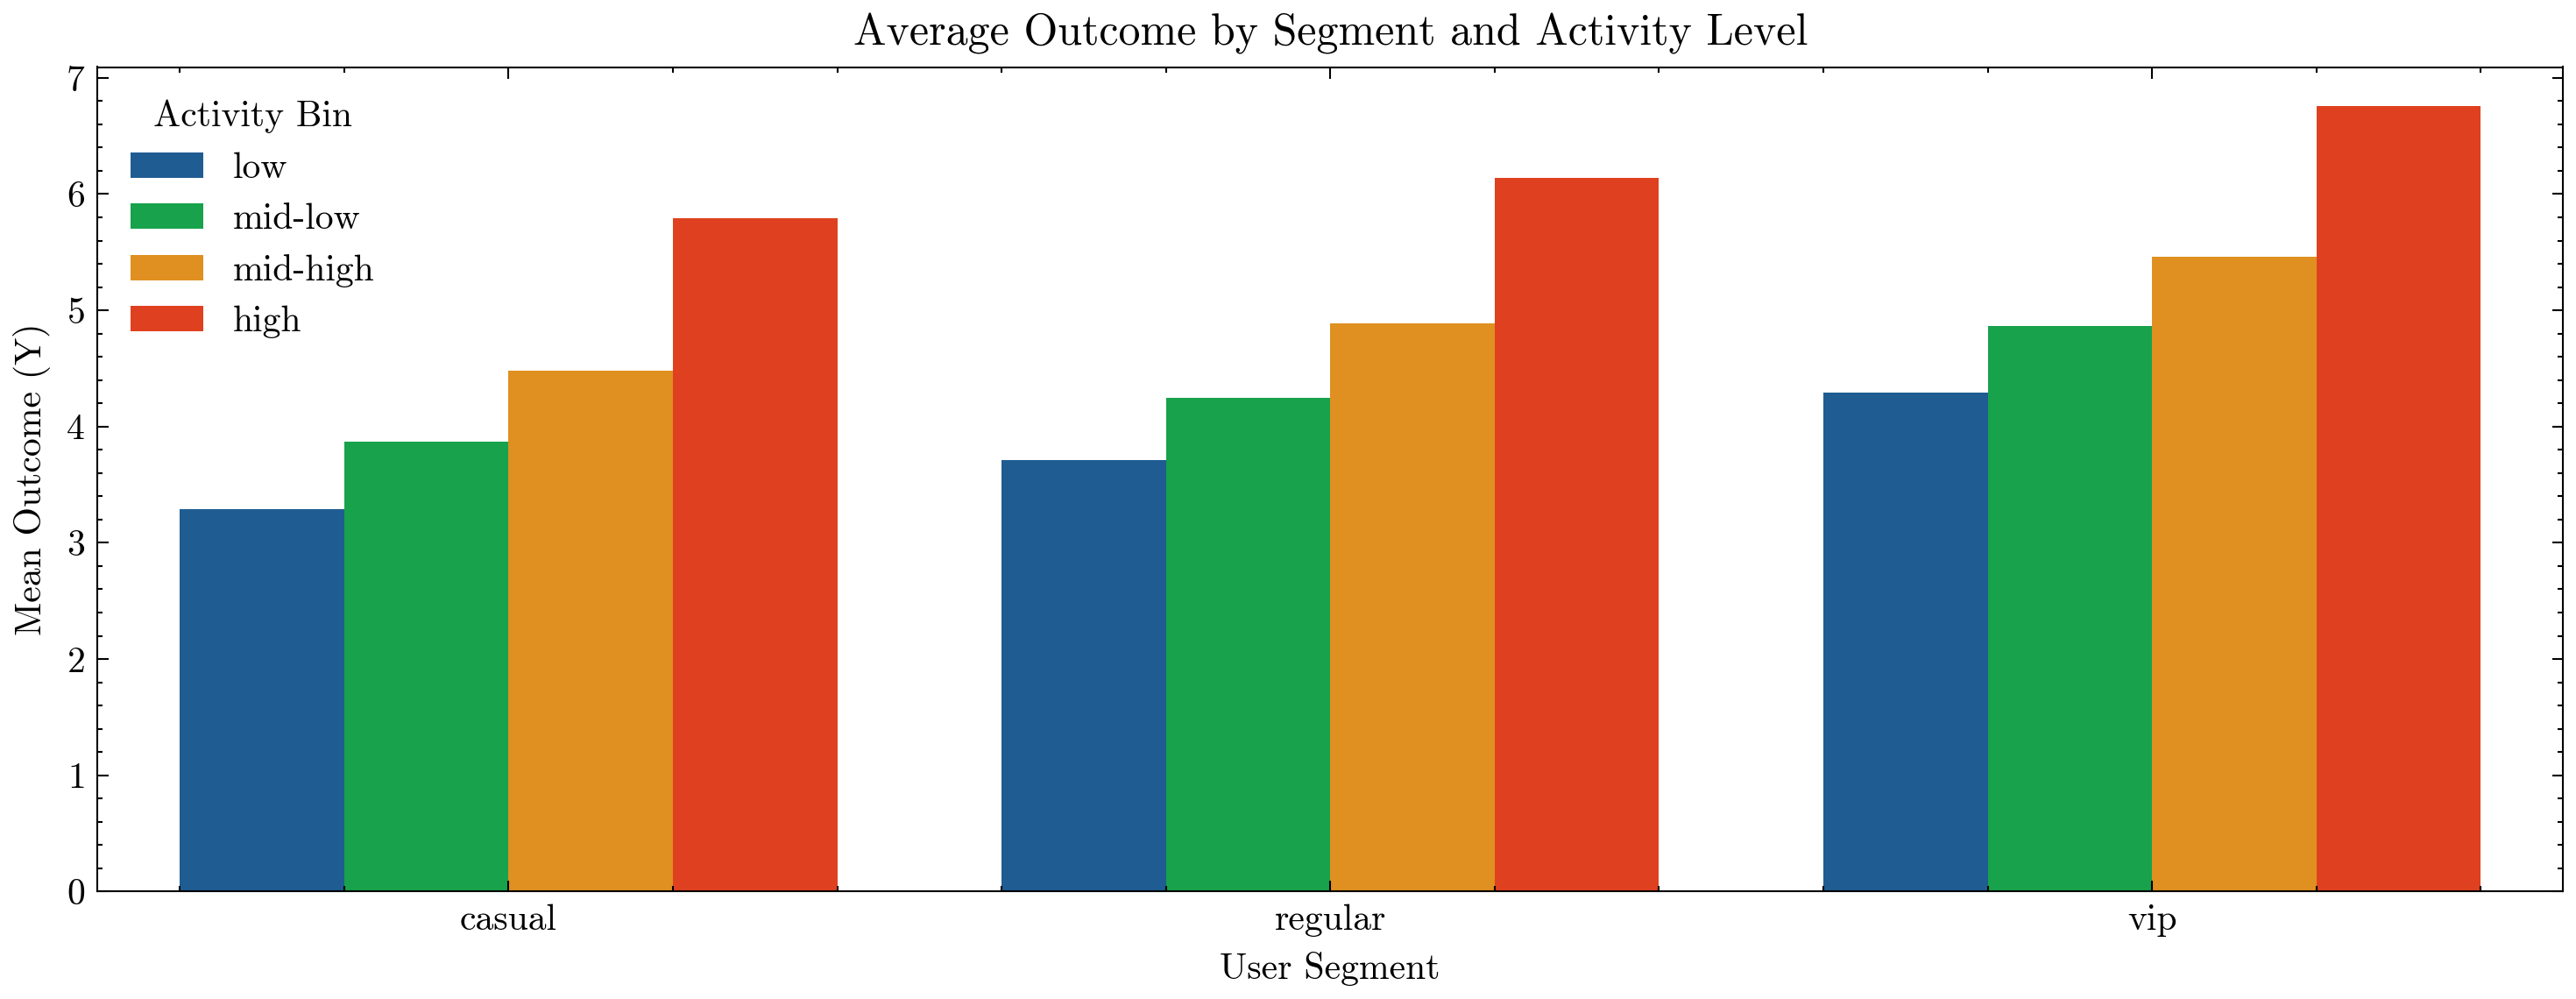

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', 'no-latex'])

plt.figure(figsize=(10,4), dpi=300)
sns.barplot(
    data=cohort_summary,
    x="segment", y="avg_outcome", hue="activity_bin",
    ci=None
)
plt.title("Average Outcome by Segment and Activity Level")
plt.ylabel("Mean Outcome (Y)")
plt.xlabel("User Segment")
plt.legend(title="Activity Bin")
plt.tight_layout()
plt.show()


## 🧩 Interpreting Cohort Results

Each row represents a **subpopulation** — e.g., *regular* users with *mid-high* activity who signed up in *month 3*.  

**Columns:**
- `n_users` → number of users in this slice  
- `avg_pre_metric` → baseline performance before the experiment  
- `treat_rate` → fraction of users who received the treatment  
- `avg_exposure` → average treatment intensity (dose)  
- `avg_outcome` → observed outcome  

These summaries tell us if:
- The **treatment rate** is balanced across segments (a check for fair randomization),
- There’s **exposure bias** (some groups have higher exposure regardless of treatment),
- Different cohorts yield different outcomes (potential **CATE** patterns).

### Example questions for agents:
- Are VIPs more sensitive to the same treatment?  
- Do low-activity users need higher exposure to see benefit?  
- Is eligibility (E) concentrated in particular cohorts?

Super agents can use such cohort insights to design **targeted experiments** and **adaptive policies** that dynamically personalize interventions by user type.

## 🎲 Using Cohorts to Create A/B Test Splits

Once we have user **cohorts** (e.g. by `segment`, `activity_bin`, `age_bin`, etc.), we can use them in two main ways when assigning A/B groups:

1. **Global randomization**  
   - Every user is independently assigned to control (A) or variant (B) with some probability (e.g. 50/50).  
   - Simple and often sufficient when the population is large and roughly balanced.

2. **Stratified randomization (by cohort)**  
   - We *first* define strata, e.g. by `segment × activity_bin`.  
   - Within each stratum, we randomize users into A/B with the desired proportion.  
   - This guarantees that **each cohort has balanced A/B groups**, which:
     - Reduces variance,
     - Avoids accidental imbalances (e.g. VIPs over-represented in one arm),
     - Makes it easier to analyze **heterogeneous treatment effects** later.

For **super agents**, stratified randomization is especially powerful:
- The agent can ensure **fair exploration** across user types.
- It can later learn **policy rules per cohort** (e.g. different actions for VIP vs casual).
- It prevents the agent from overfitting to whichever segment was over-sampled by chance.

In [12]:
import numpy as np

# For reproducibility
rng = np.random.default_rng(2025)

# -------------------------------
# 1) Simple global randomization
# -------------------------------
# ab_group = 0 (control), 1 (treatment)
df["ab_group_global"] = rng.binomial(1, 0.5, size=df.shape[0])

# Quick sanity check: overall split
print("Global A/B split:")
print(df["ab_group_global"].value_counts(normalize=True).round(3))


# ------------------------------------
# 2) Stratified randomization by cohort
# ------------------------------------
# Here we stratify by segment x activity_bin
# (you can also use ['segment', 'activity_bin', 'age_bin'] if already created)

if "activity_bin" not in df.columns:
    # create an activity bin if not already present
    df["activity_bin"] = pd.qcut(df["activity_score"], q=4, labels=["low", "mid-low", "mid-high", "high"])

strata_cols = ["segment", "activity_bin"]

def assign_stratified(group, p=0.5, rng=None):
    """Randomly assign treatment within each cohort group with proportion p."""
    n = group.shape[0]
    n_treat = int(round(p * n))
    # Permute indices within group
    idx = rng.permutation(n)
    # Start with all zeros (control)
    ab = np.zeros(n, dtype=int)
    # First n_treat indices become 1 (treatment)
    ab[idx[:n_treat]] = 1
    group = group.copy()
    group["ab_group_strat"] = ab
    return group

df = df.groupby(strata_cols, group_keys=False).apply(assign_stratified, p=0.5, rng=rng)

# Check balance: treatment rate per cohort under stratified scheme
cohort_balance = (
    df.groupby(strata_cols)
      .agg(
          n_users=("Y", "size"),
          treat_rate_global=("ab_group_global", "mean"),
          treat_rate_strat=("ab_group_strat", "mean")
      )
      .reset_index()
      .sort_values(strata_cols)
)

print("\nPer-cohort treatment rates (global vs stratified):")
display(cohort_balance.head(20))

Global A/B split:
ab_group_global
0    0.506
1    0.494
Name: proportion, dtype: float64

Per-cohort treatment rates (global vs stratified):


,segment,activity_bin,n_users,treat_rate_global,treat_rate_strat
0,casual,low,6233,0.489331,0.499920
1,casual,mid-low,6176,0.495466,0.500000
2,casual,mid-high,6173,0.496031,0.499919
3,casual,high,6294,0.506832,0.500000
4,regular,low,4980,0.489157,0.500000
5,regular,mid-low,5093,0.488514,0.499902
6,regular,mid-high,5083,0.493213,0.500098
7,regular,high,5013,0.484740,0.499900
8,vip,low,1287,0.494949,0.500389
9,vip,mid-low,1231,0.510154,0.500406


## 📊 Interpreting Global vs Stratified Assignment

In the `cohort_balance` table:

- `treat_rate_global` is the **observed** fraction in treatment under simple global randomization.
  - This should be close to 0.5 overall, but can drift within small cohorts (e.g. VIP + low activity might end up 70/30 by chance).

- `treat_rate_strat` is the treatment fraction under **stratified randomization**.
  - This should be very close to the target (≈ 0.5) **inside every (segment × activity_bin) cohort**.

### Why this matters for agents

For a **super agent** deciding which users see a new policy:

- **Global randomization** is easy but can accidentally over-treat or under-treat certain groups.
- **Stratified randomization** ensures every cohort (e.g. `vip + high activity`) gets a fair share of both A and B.
- Later, when we estimate effects (ATE, CATE), we can be confident that differences we see between cohorts are **real** and not an artefact of imbalanced assignment.

This is how agents can:
- Explore **fairly** across heterogeneous users,
- Learn **segment-specific** policies,
- And avoid “oh no, all my VIPs ended up in control” moments.

## 📈 Power Analysis via Increasing A/B Sample Sizes  
*A simulation-driven way to understand how many users your experiment needs to reliably detect an effect.*

Traditional power analysis relies on assumptions about variances and effect sizes.  
But when working with **realistic agent environments**, **heterogeneous cohorts**, or **non-Gaussian outcomes**, it is often more intuitive — and more accurate — to estimate power **empirically**.

In this approach, we repeatedly run *mini-experiments* of increasing sample sizes and observe when the experiment becomes statistically significant.


### 🔍 Why the `sub['T']` Filter Matters  
In real systems, users may **not always receive the assigned treatment** due to eligibility, delivery constraints, or exploration policies.  
Therefore:

- **Control group (A)** = users who were **assigned control (`ab_group_global == 0`) AND did not receive treatment (`T == 0`)**  
- **Test group (B)** = users who were **assigned test (`ab_group_global == 1`) AND actually received treatment (`T == 1`)**

This ensures we compare:
- **Pure controls** who saw no treatment  
vs  
- **Actual treated users** who received the full effect  

This distinction is **crucial** for agent experimentation, where compliance may not be perfect and treatments may depend on model logic, eligibility, or action constraints.


### 🧪 Step-by-Step Procedure

1. **Choose sample sizes**  
   We test a range: n = 1, 20, 40 ... 190. Each value represents a *hypothetical experiment size*.
2. **For each sample size:**
- Randomly draw a subset of `n` users from the population.
- Split them into:
  - **Control**: users assigned to control AND not treated (`A`)
  - **Test**: users assigned to test AND treated (`B`)
- Compute:
  - Mean difference in outcome `Y`
  - A **two-sample Welch t-test**
- Record the **p-value**.

3. **Plot**:
- `p-value vs sample size`
- A significance line at `p = 0.01` (or 0.05)

4. **Determine the minimum sample size**  
The smallest `n` for which **p < 0.01** tells us:

> "This is the minimum user count a real experiment would need for the super agent to reliably detect the underlying treatment effect."


### 📊 What This Shows

This simulation reveals how detection power increases with sample size:

- At **small n**, randomness dominates — p-values are high.  
- As **n increases**, the sampling noise shrinks, and the treatment–control difference becomes easier to detect.  
- Once the p-value crosses below the threshold, the experiment has **enough power** to distinguish signal from noise.

This is exactly how an **agent’s exploration policy** can adapt:
- Wider exploration when sample sizes are small or uncertainty is high,
- More confident exploitation once the agent has sufficient statistical evidence.


### 🤖 Why This Matters for Super Agents

A super agent must decide:
- *How many users should I explore on?*
- *Is the effect strong enough to justify rollout?*
- *What is the statistical confidence in my updated policy?*

This data-driven power curve directly answers those questions.

It transforms experimentation from a fixed offline calculation into a **dynamic learning process**, enabling agentic systems to make scientifically grounded, statistically robust decisions about:
- policy rollout,
- feature launches,
- personalization strategies,
- reinforcement learning reward updates,
- and multi-agent coordination.

By integrating power estimation into its reasoning loop, a super agent becomes safer, more efficient, and more reliable in the real world.

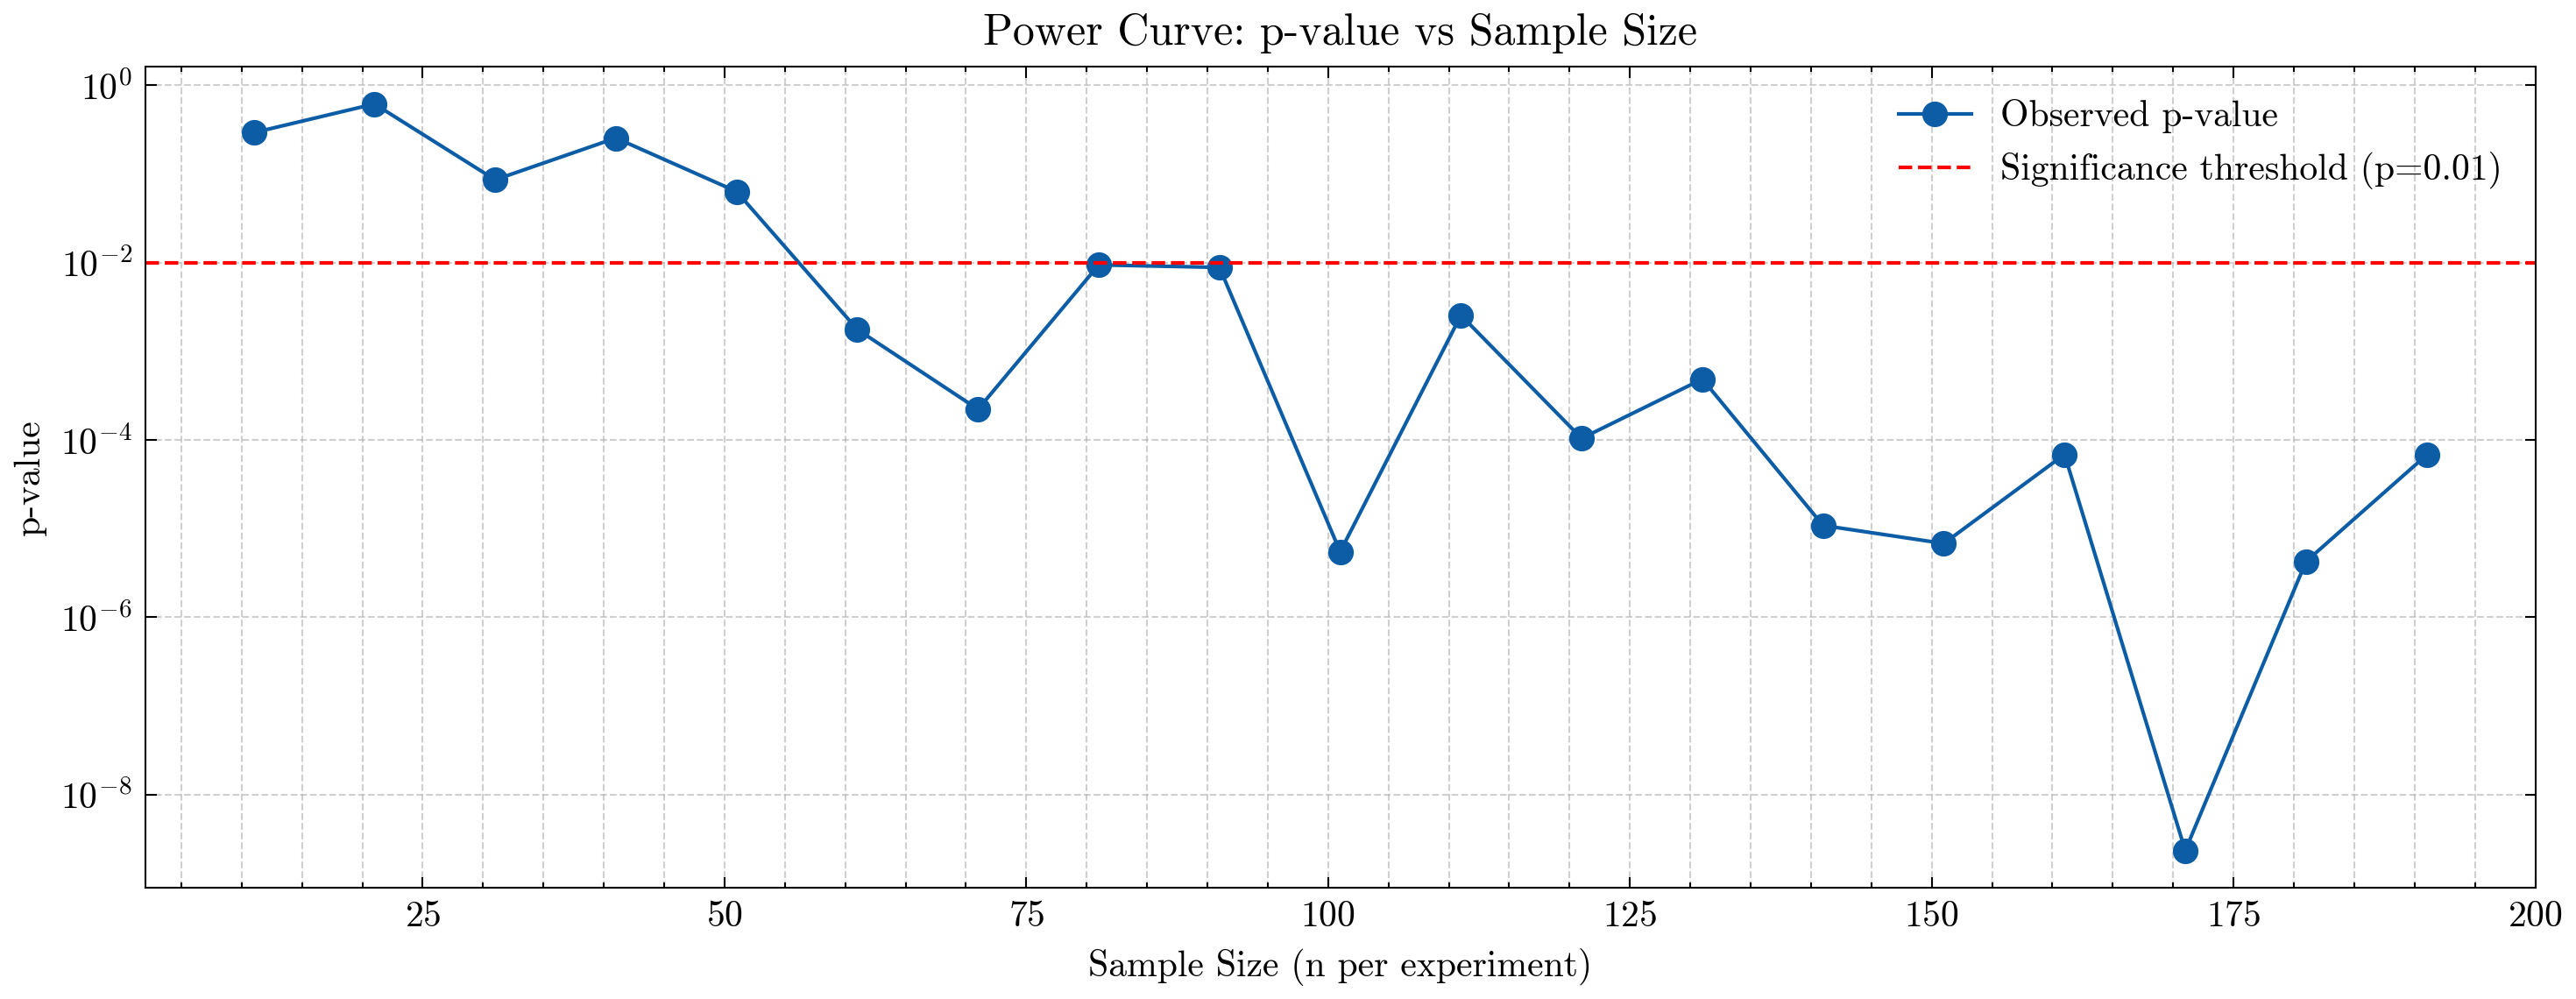

🔥 Minimum required sample size to reach p < 0.01: 61


In [28]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

rng = np.random.default_rng(999)

# Choose which A/B assignment to use
AB_COL = "ab_group_global"   # or "ab_group_global"

# Increasing sample sizes to test
sample_sizes = np.arange(1, 200, 10)

p_values = []
diff_means = []

for n in sample_sizes:
    # Subsample users
    sub = df.sample(n=n, random_state=rng.integers(1e9))
    
    # Split into A/B
    a = sub[(sub[AB_COL] == 0) & (sub['T'] == 0)]["Y"]
    b = sub[(sub[AB_COL] == 1) & (sub['T'] == 1)]["Y"]
    
    # T-test
    t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)
    
    p_values.append(p_val)
    diff_means.append(b.mean() - a.mean())

# Find first n where p < 0.01
sig_threshold = 0.01
significant_ns = [n for n, p in zip(sample_sizes, p_values) if p < sig_threshold]

min_n_required = significant_ns[0] if significant_ns else None

plt.figure(figsize=(10,4), dpi=300)
plt.plot(sample_sizes, p_values, marker="o", label="Observed p-value")
plt.axhline(0.01, color="red", linestyle="--", label="Significance threshold (p=0.01)")
plt.title("Power Curve: p-value vs Sample Size")
plt.xlabel("Sample Size (n per experiment)")
plt.ylabel("p-value")
plt.yscale("log")  # helpful since p-values shrink exponentially
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

if min_n_required is not None:
    print(f"🔥 Minimum required sample size to reach p < 0.01: {min_n_required}")
else:
    print("❗Even at the largest tested sample size, the effect was not significant.")


## 📊 Interpreting the Power Curve

The plot shows how the **p-value** from our mini A/B experiments changes as we increase the **sample size**.

Each point represents:
- A random subsample of `n` users,
- Split into control (A) and treated (B),
- Computed difference in outcomes `Y`,
- And a two-sample t-test to see whether the effect is detectable.

Because p-values shrink as statistical evidence grows, the curve typically slopes downward as `n` increases.


### 🎉 Required Sample Size: **61 Users**

The red dashed line marks the significance threshold at **p = 0.01**.

Our curve crosses that line at:

> **n = 61**

This means:
- Any experiment with **fewer than 61 users** is *too underpowered* — random noise overwhelms the true treatment effect.
- Once we have **61 or more users**, the effect becomes **statistically detectable** at the 1% confidence level.
- Beyond this point, p-values continue dropping as we gain more evidence.


### 🧠 Intuition

Small experiments behave like small telescopes — the signal is blurry and noisy.  
As sample size grows:
- The noise averages out,
- Differences between control and treatment stabilize,
- And the statistical test becomes sharper.

By the time we hit **61 users**, the experiment has gathered enough evidence that the treatment effect reliably stands out from randomness.

## 🧪 A/B Testing with CUPED Variance Reduction

Once we’ve randomly assigned users into **control** and **test** groups, the simplest way to evaluate an experiment is:

> Compare the average outcome in test vs control.

However, the raw outcome `Y` can be noisy. If we have a **pre-period metric** `pre_metric` (e.g. user’s baseline activity before the experiment), we can use **CUPED** to *reduce variance* and get more precise estimates with the **same sample size**.


### 🧠 Intuition: What is CUPED?

CUPED stands for **Controlled-experiment Using Pre-Experiment Data**.

Idea:
- If pre-period behavior is **correlated** with post-period outcomes, we can “subtract out” the predictable part.
- This shrinks noise and **tightens confidence intervals**, without changing the average treatment effect.

Mathematically, we define an adjusted outcome:

$$Y^* = Y - \theta (X - \bar X)$$

Where:
- $Y$ = post-period outcome (e.g., `Y_exp`),
- $X$ = pre-period metric (e.g., `pre_metric`),
- $\bar X$ = mean of $X$ over all users,
- $\theta = \frac{\mathrm{Cov}(Y, X)}{\mathrm{Var}(X)}$.

Key properties:
- The **expected A/B difference in $Y^*$** is the same as in $Y$ (no bias),
- But the **variance of $Y^*$** is smaller when $X$ is correlated with $Y$,
- In practice, this means we either:
  - Need **fewer users** for the same power, or  
  - Get **more power** for the same number of users.


### 🧬 What We’ll Do

1. Compute the **naive A/B effect** using the raw outcome `Y_exp`.
2. Estimate the CUPED adjustment parameter $\theta$.
3. Create the CUPED-adjusted outcome `Y_cuped`.
4. Re-run the A/B test on `Y_cuped`.
5. Compare:
   - Effect estimates,
   - Standard errors,
   - Percent variance reduction.

This is exactly how a **super agent** can leverage historical behavior to:
- Stabilize online experiments,
- Get faster readouts,
- And make more confident policy decisions with fewer users.


In [30]:
import numpy as np
import pandas as pd
from scipy import stats

# ------------------------------------------------------
# Config: which A/B assignment and outcome are we using?
# ------------------------------------------------------
AB_COL = "ab_group_strat"   # 0 = control, 1 = test
OUTCOME_COL = "Y"       # post-experiment outcome
PRE_COL = "pre_metric"      # pre-period metric for CUPED

# --- 1) Naive A/B effect on raw outcome ---------------------------
control = df.loc[df[AB_COL] == 0, OUTCOME_COL]
test    = df.loc[df[AB_COL] == 1, OUTCOME_COL]

naive_diff = test.mean() - control.mean()
t_stat_naive, p_val_naive = stats.ttest_ind(test, control, equal_var=False)

naive_var = 0.5*(control.var(ddof=1) + test.var(ddof=1))  # rough pooled variance

print("=== Naive A/B (raw outcome) ===")
print(f"Control mean: {control.mean():.4f}")
print(f"Test    mean: {test.mean():.4f}")
print(f"Diff (Test - Control): {naive_diff:.4f}")
print(f"t-statistic: {t_stat_naive:.3f}, p-value: {p_val_naive:.4f}")
print(f"Approx pooled variance: {naive_var:.4f}\n")

# --- 2) Estimate CUPED theta --------------------------------------
X = df[PRE_COL].values
Y = df[OUTCOME_COL].values

theta = np.cov(Y, X, ddof=1)[0, 1] / np.var(X, ddof=1)
print(f"CUPED theta (Cov(Y, X)/Var(X)): {theta:.4f}")

# --- 3) Build CUPED-adjusted outcome -------------------------------
df["Y_cuped"] = df[OUTCOME_COL] - theta * (df[PRE_COL] - df[PRE_COL].mean())

cuped_control = df.loc[df[AB_COL] == 0, "Y_cuped"]
cuped_test    = df.loc[df[AB_COL] == 1, "Y_cuped"]

cuped_diff = cuped_test.mean() - cuped_control.mean()
t_stat_cuped, p_val_cuped = stats.ttest_ind(cuped_test, cuped_control, equal_var=False)

cuped_var = 0.5*(cuped_control.var(ddof=1) + cuped_test.var(ddof=1))

print("\n=== CUPED A/B (adjusted outcome) ===")
print(f"Control mean (CUPED): {cuped_control.mean():.4f}")
print(f"Test    mean (CUPED): {cuped_test.mean():.4f}")
print(f"Diff (Test - Control): {cuped_diff:.4f}")
print(f"t-statistic: {t_stat_cuped:.3f}, p-value: {p_val_cuped:.4f}")
print(f"Approx pooled variance (CUPED): {cuped_var:.4f}\n")

# --- 4) Compare variance / precision -------------------------------
var_reduction = 1 - cuped_var / naive_var
print(f"✅ Approximate variance reduction from CUPED: {100*var_reduction:.1f}%")


=== Naive A/B (raw outcome) ===
Control mean: 4.6116
Test    mean: 4.6110
Diff (Test - Control): -0.0006
t-statistic: -0.032, p-value: 0.9742
Approx pooled variance: 4.0312

CUPED theta (Cov(Y, X)/Var(X)): 0.7767

=== CUPED A/B (adjusted outcome) ===
Control mean (CUPED): 4.6038
Test    mean (CUPED): 4.6188
Diff (Test - Control): 0.0150
t-statistic: 1.013, p-value: 0.3110
Approx pooled variance (CUPED): 2.7241

✅ Approximate variance reduction from CUPED: 32.4%


### 📉 Interpreting CUPED Results

Comparing the **naive** and **CUPED** outputs:

- The **mean effect (Test − Control)** should be very similar in both:
  - CUPED is *unbiased* — it doesn’t change the expected treatment effect.
- The **variance / p-value** usually improves with CUPED:
  - Lower variance → larger t-stat → smaller p-value.
  - This corresponds to a **higher powered experiment** with the same data.

The printed line:

> `✅ Approximate variance reduction from CUPED: 32.4%`

tells you how much variance you shaved off.

For example, if you see:

```
Approx pooled variance: 4.03 (naive)  
Approx pooled variance (CUPED): 2.72
Variance reduction: 32%
```

that means your experiment is now, roughly, as powerful as it would have been with **~30% more users** under the naive design.


### 🤖 CUPED for Super Agents

For a **super agent** that runs many experiments or continuously tweaks policies:

- CUPED allows **faster learning** from the same user traffic.
- It makes metrics more **stable** and **less noisy**, especially when user behavior is heavy-tailed or highly variable.
- It leverages **rich historical baselines** (pre_metric) the agent naturally observes in production.

In practice, agents can:
- Use CUPED-adjusted outcomes for their internal evaluation loops,
- Combine them with CATE models to understand **who** benefits most from interventions,
- And evolve toward **smaller, more efficient experiments** that respect user experience while still being statistically rigorous.


## 🧮 OLS vs 2SLS: Causal Estimation Beyond Simple A/B

So far, we’ve seen **A/B tests** where treatment assignment is randomized and clean.  
But super agents often have to learn from **observational logs** where treatment `T` is **not randomized**:

- the agent decides whom to treat (policy logic),
- more active / high-value users are more likely to be treated,
- eligibility, exposure, and hidden traits all influence both **treatment** and **outcome**.

In our synthetic world, that’s exactly what’s happening:
- `T` (treatment) is affected by:
  - **observed confounders**: `age`, `activity_score`, `segment`, `E` (eligibility),
  - **unobserved confounder**: `u_latent` (latent inclination; not in `df`),
  - **instrument**: `Z` (randomized encouragement).

We want to know the **causal effect** of treatment on outcome:

$$\tau = \mathbb{E}[Y(1) - Y(0)]$$

We planted the true structural effect `tau = 1.2` in the data generator — so we can see which methods recover it.



### 1️⃣ OLS (Ordinary Least Squares)

**OLS** fits a linear model:

$$Y = \alpha + \tau T + \beta^\top X + \varepsilon$$

Where:
- $Y$ = outcome (e.g. revenue, retention),
- $T$ = treatment indicator (0/1),
- $X$ = covariates (age, activity, segment, eligibility),
- $\tau$ = coefficient on $T$ — interpreted as *causal* only if:
  - **No unobserved confounding**, and
  - The model is correctly specified.

We’ll look at:

1. **Naive OLS**: `Y ~ T` (ignores all confounders).  
2. **Back-door OLS**: `Y ~ T + age + activity + segment + E`  
   (controls for observed confounders that we think block back-door paths).

**Why it can fail:**  
Even with good covariates, if there’s an unobserved `U` that affects both `T` and `Y`, OLS remains biased. That’s the classic **endogeneity** problem.

This is what often happens in production logs: the super agent **targets “good” users**, so treated users would have done well anyway.


### 2️⃣ 2SLS (Two-Stage Least Squares) with an Instrument

To fix unobserved confounding, we can use an **instrumental variable** `Z`:

- `Z` = randomized encouragement (e.g. some users randomly see a nudge that increases their chance of receiving treatment),
- Valid if:
  1. **Relevance**: `Z` changes treatment (`Z → T`),
  2. **Exclusion**: `Z` affects `Y` **only through** `T`, not directly or through other paths,
  3. **Independence**: `Z` is independent of unobserved shocks to `Y` (because it was randomized).

**2SLS algorithm:**

1. **Stage 1 (first stage):**  
   Predict treatment from instrument + covariates:

   $$   T = \pi_0 + \pi_1 Z + \gamma^\top X + \nu $$

   Get **predicted treatment** $\hat T$.

2. **Stage 2:**  
   Regress outcome on predicted treatment:

   $$   Y = \alpha + \tau_{\text{IV}} \hat T + \delta^\top X + \epsilon$$

   The coefficient $\tau_{\text{IV}}$ is the **IV / 2SLS estimate** — a *causal* effect for the “compliers” (those whose treatment status is shifted by `Z`).


### 🧪 Why This Matters for Super Agents

For a super agent:

- **OLS** is like “just run a regression on logs” — easy, but fragile if the agent already biases who gets treated.
- **2SLS with encouragement experiments** is like:
  - the agent occasionally **nudges random users** (encouragement `Z`),
  - then uses those nudges as an **instrument** to learn a *causal* effect of its actions, despite hidden confounding.

In other words:
- **A/B tests** help the agent learn causal effects in clean experiments (`ab_group`).
- **IV/2SLS** helps the agent learn causal effects **from its own logged behavior**, when full randomization is not possible, but weaker random signals (like encouragements or exploration actions) exist.

Next, we’ll implement:

1. Naive OLS,
2. Back-door OLS,
3. 2SLS IV (Z → T → Y),

and compare them to the true structural effect `tau = 1.2`.


In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from sklearn.preprocessing import OneHotEncoder

# We assume df already exists from the simulation:
# columns: ["segment", "age", "activity_score", "E", "Z", "T", "Y", "pre_metric", ...]

# -------------------------
# Prepare covariates (X)
# -------------------------
enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
seg_oh = enc.fit_transform(df[["segment"]])
seg_cols = [f"segment_{c}" for c in enc.categories_[0][1:]]
X_seg = pd.DataFrame(seg_oh, columns=seg_cols, index=df.index)

# Common covariate matrix for back-door and IV
X_cov = pd.concat(
    [
        X_seg,
        df[["age", "activity_score", "E"]],  # observed confounders
    ],
    axis=1
)

Y = df["Y"]
T = df["T"]
Z = df["Z"]

# -------------------------
# 1) Naive OLS: Y ~ T
# -------------------------
X_naive = add_constant(T)
ols_naive = OLS(Y, X_naive).fit()

print("=== Naive OLS: Y ~ T ===")
print(ols_naive.summary().tables[1])
print(f"Naive OLS estimate for T: {ols_naive.params['T']:.3f}\n")

# -------------------------
# 2) Back-door OLS: Y ~ T + X
# -------------------------
X_backdoor = add_constant(pd.concat([T, X_cov], axis=1))
ols_backdoor = OLS(Y, X_backdoor).fit()

print("=== Back-door OLS: Y ~ T + X (age, activity, segment, E) ===")
print(ols_backdoor.summary().tables[1])
print(f"Back-door OLS estimate for T: {ols_backdoor.params['T']:.3f}\n")

# -------------------------
# 3) 2SLS IV: Z as instrument for T
#     Stage 1: T ~ Z + X_cov
#     Stage 2: Y ~ T_hat + X_cov
# -------------------------

# Stage 1
X_stage1 = add_constant(pd.concat([Z, X_cov], axis=1))
stage1 = OLS(T, X_stage1).fit()
T_hat = stage1.fittedvalues

# Give the predicted treatment a proper name so statsmodels labels the coefficient nicely
T_hat = T_hat.rename("T_hat")

print("=== 2SLS Stage 1: T ~ Z + X ===")
print(stage1.summary().tables[1])
print()

# Stage 2
X_stage2 = add_constant(pd.concat([T_hat, X_cov], axis=1))
stage2 = OLS(Y, X_stage2).fit()

print("=== 2SLS Stage 2: Y ~ T_hat + X ===")
print(stage2.summary().tables[1])
print(f"2SLS IV estimate for T_hat: {stage2.params['T_hat']:.3f}\n")

# Compare to true tau if you have it
true_tau = 1.2
print(f"True structural treatment effect tau: {true_tau:.3f}")
print(f"Naive OLS:      {ols_naive.params['T']:.3f}")
print(f"Back-door OLS:  {ols_backdoor.params['T']:.3f}")
print(f"2SLS IV:        {stage2.params['T_hat']:.3f}")

=== Naive OLS: Y ~ T ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4239      0.013    273.544      0.000       3.399       3.448
T              1.9671      0.016    122.097      0.000       1.936       1.999
Naive OLS estimate for T: 1.967

=== Back-door OLS: Y ~ T + X (age, activity, segment, E) ===
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0970      0.027     39.910      0.000       1.043       1.151
T                   1.8977      0.013    146.591      0.000       1.872       1.923
segment_regular     0.3901      0.013     29.226      0.000       0.364       0.416
segment_vip         0.9947      0.022     45.384      0.000       0.952       1.038
age                 0.0193      0.001     29.434      0.000  

### 🔍 Interpreting OLS vs 2SLS Results

From the printed estimates:

- **Naive OLS (Y ~ T)**  
  Typically **overestimates** the effect, because treated users tend to be “better” users (higher `U`, `activity_score`, `E`).

- **Back-door OLS (Y ~ T + X)**  
  Adjusts for observed confounders:
  - age,
  - activity_score,
  - segment,
  - eligibility `E`.

  This usually moves the estimate closer to the true `tau = 1.2`, but may still be biased if unobserved `U` matters.

- **2SLS IV (Z → T → Y)**  
  Uses randomized encouragement `Z` to isolate **exogenous variation** in treatment:
  - Stage 1: how much `Z` moves `T`,
  - Stage 2: how those instrument-driven changes in `T` move `Y`.

  The 2SLS estimate for `T_hat` should land **closest to the true tau**, within sampling noise.

This shows a realistic pattern:

> Regression on logs alone (naive OLS) overstates the effect.  
> Adding controls helps, but doesn’t fully fix hidden bias.  
> IV/2SLS, when a good instrument exists, recovers the causal effect more reliably.


### 🤖 How Super Agents Use This

In an agentic system:

- **When full A/B randomization is possible**  
  → use classic experimentation (ab_group) and CUPED for variance reduction.

- **When you mostly have observational logs, but can sprinkle random nudges**  
  → treat those nudges (`Z`) as instruments and use **2SLS** to learn causal effects.

- **When designing new policies**  
  → combine:
  - A/B tests for clean estimates on new ideas,
  - OLS/back-door adjustment for quick, approximate effects,
  - IV/2SLS for robust causal learning when randomization is partial or policy-driven.

This is how a super agent can **continuously learn causally** in complex, biased environments — not just reactively fit patterns, but understand *what truly works and why*.

## 📡 Exposure Bias: Why “Only Exposed Users” Can Mislead You

In many real systems, not everyone can even *see* a treatment:

- Only eligible users can receive a bonus,
- Only high-activity users see a new feed,
- Only certain journeys reach a particular agent policy.

In our data, this is captured by **eligibility** `E` and **exposure**:

- `E = 1` → user is *eligible* to get the treatment and exposure,
- `exposure` → how many times they actually experienced the treatment.

Crucially:
- More active / “better” users are **more likely to be eligible** (`E=1`),
- They also tend to have **higher outcomes** `Y` *even without* treatment.

If we naively analyze **only users with `E=1`**, we’re looking at a **selected subpopulation** that is not representative of the full user base.  
This is **exposure bias** / **selection bias**.


### 🔍 Where Does 2SLS Help, and Where Does It Struggle?

Earlier, we used 2SLS with instrument `Z` (randomized encouragement) to handle **unobserved confounding** (`U`, latent inclination) when estimating the effect of `T` on `Y`.

But if we **restrict our analysis to \(E=1\)**:
- We are conditioning on a variable (`E`) that is *downstream* of other drivers (like `activity_score`),
- The subpopulation might overweight heavy users,
- Our IV estimate now becomes a **local effect for exposed, selected users**, which may **not** match the population-level effect.

So we have *two* problems:
1. Endogeneity of treatment (`T` ↔ `U`): fixed by IV/2SLS.
2. Selection into exposure (`E`): a **separate** bias, not fixed by IV alone.


### 🛠 IPW (Inverse Probability Weighting) as a Fix

**Idea:**  
If we only observe outcomes for `E=1` (the exposed/eligible users), we can try to recover what would happen in the **full population** by **reweighting** these exposed users.

Steps:

1. Model the **probability of being exposed/eligible**:
   $$ p_i = P(E_i = 1 \mid X_i)$$
   using observed covariates \(X\) (segment, age, activity).

2. For users with `E=1`, define a weight:
   $$   w_i = \frac{1}{p_i}$$
   Intuition: users with *low* exposure probability (rarely eligible) get **higher weight**, because each such user represents “more” of the unseen population.

3. Run a **weighted 2SLS** (IPW + IV):
   - Stage 1: weighted regression of `T` on `Z` and `X`,
   - Stage 2: weighted regression of `Y` on predicted `T_hat` and `X`.

This gives us an **IPW-2SLS estimate** that:
- Uses `Z` to handle unobserved confounding (via 2SLS),
- Uses weights `w` to handle selection into `E=1` (exposure bias).


### 🤖 Why This Matters for Super Agents

A super agent in production usually:

- Doesn’t treat everyone,
- Treats only those who are **eligible** according to business rules or operational constraints,
- Logs outcomes only for users who reached certain states or surfaces.

Naively learning only from “seen” or “exposed” users leads to **optimism bias** and policies that overfit to heavy users.

By combining:

- **2SLS (IV)** → to get causal effects from policy-driven logs,
- **IPW** → to correct for who gets **exposed** to the policy at all,

a super agent learns **robust causal effects** even in the presence of:

- Endogenous treatment decisions,
- Skewed exposure / eligibility,
- Selection on observables.

This is essential for deploying agents as *scientific learners* in complex systems.

In [42]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS, WLS, add_constant
from sklearn.preprocessing import OneHotEncoder
from statsmodels.discrete.discrete_model import Logit

# --------------------------------------------------
# 0) Prepare covariates and basic objects
# --------------------------------------------------
# One-hot encode segment as before
enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
seg_oh = enc.fit_transform(df[["segment"]])
seg_cols = [f"segment_{c}" for c in enc.categories_[0][1:]]
X_seg = pd.DataFrame(seg_oh, columns=seg_cols, index=df.index)

# Common covariates for confounding/exposure models
X_cov = pd.concat(
    [
        X_seg,
        df[["age", "activity_score"]],  # core observed confounders
    ],
    axis=1
)

Y = df["Y"]
T = df["T"]
Z = df["Z"]
E = df["E"]

# --------------------------------------------------
# 1) Baseline 2SLS on full population
# --------------------------------------------------
# Stage 1: T ~ Z + X_cov
X1_full = add_constant(pd.concat([Z, X_cov], axis=1))
stage1_full = OLS(T, X1_full).fit()
T_hat_full = stage1_full.fittedvalues
T_hat_full = T_hat_full.rename("T_hat")

# Stage 2: Y ~ T_hat + X_cov
X2_full = add_constant(pd.concat([T_hat_full, X_cov], axis=1))
stage2_full = OLS(Y, X2_full).fit()
tau_full_iv = stage2_full.params["T_hat"]

print("=== Baseline 2SLS on full population ===")
print(f"2SLS estimate (full): {tau_full_iv:.3f}")
print()

# --------------------------------------------------
# 2) 2SLS restricted to exposed/eligible users only (E == 1)
#    This mimics the common mistake: analyze only users who
#    reached the treatment surface / were eligible.
# --------------------------------------------------
mask_exp = (E == 1)
df_exp = df.loc[mask_exp]
X_cov_exp = X_cov.loc[mask_exp]
Y_exp = Y.loc[mask_exp]
T_exp = T.loc[mask_exp]
Z_exp = Z.loc[mask_exp]

# Stage 1 on exposed subset
X1_exp = add_constant(pd.concat([Z_exp, X_cov_exp], axis=1))
stage1_exp = OLS(T_exp, X1_exp).fit()
T_hat_exp = stage1_exp.fittedvalues
T_hat_exp = T_hat_exp.rename("T_hat")

# Stage 2 on exposed subset
X2_exp = add_constant(pd.concat([T_hat_exp, X_cov_exp], axis=1))
stage2_exp = OLS(Y_exp, X2_exp).fit()
tau_exp_iv = stage2_exp.params["T_hat"]

print("=== 2SLS on exposed-only subset (E == 1) ===")
print(f"2SLS estimate (exposed-only): {tau_exp_iv:.3f}")
print("Note: This is typically biased due to selection into E=1.\n")

# --------------------------------------------------
# 3) IPW-2SLS: Correct exposure selection with weights
#    Idea: Model P(E=1 | X), then weight exposed users by 1 / P(E=1 | X).
# --------------------------------------------------

# 3a) Fit propensity model for exposure: E ~ X_cov (on full data)
X_exp_model = add_constant(X_cov)
logit_E = Logit(E, X_exp_model).fit(disp=False)
p_E = logit_E.predict(X_exp_model).clip(1e-3, 1-1e-3)

# For users we actually see (E=1), define IPW weights:
# w_i = 1 / P(E=1 | X_i)
w_ipw_full = 1.0 / p_E
w_exp = w_ipw_full[mask_exp]

# 3b) Weighted 2SLS on exposed subset
# Stage 1 (weighted): T_exp ~ Z_exp + X_cov_exp
X1_exp_w = add_constant(pd.concat([Z_exp, X_cov_exp], axis=1))
stage1_ipw = WLS(T_exp, X1_exp_w, weights=w_exp).fit()
T_hat_ipw = stage1_ipw.fittedvalues
T_hat_ipw = T_hat_ipw.rename("T_hat")

# Stage 2 (weighted): Y_exp ~ T_hat_ipw + X_cov_exp
X2_exp_w = add_constant(pd.concat([T_hat_ipw, X_cov_exp], axis=1))
stage2_ipw = WLS(Y_exp, X2_exp_w, weights=w_exp).fit()
tau_ipw_iv = stage2_ipw.params["T_hat"]

print("=== IPW-2SLS on exposed subset (E == 1) ===")
print(f"IPW-2SLS estimate (exposed-only, weighted): {tau_ipw_iv:.3f}\n")

# --------------------------------------------------
# 4) Compare everything to the true tau
# --------------------------------------------------
true_tau = 1.2  # from the data-generating process

print("=== Comparison to true effect ===")
print(f"True structural tau:           {true_tau:.3f}")
print(f"2SLS (full population):        {tau_full_iv:.3f}")
print(f"2SLS (E==1, unweighted):       {tau_exp_iv:.3f}")
print(f"IPW-2SLS (E==1, weighted):     {tau_ipw_iv:.3f}")

=== Baseline 2SLS on full population ===
2SLS estimate (full): 1.452

=== 2SLS on exposed-only subset (E == 1) ===
2SLS estimate (exposed-only): 1.433
Note: This is typically biased due to selection into E=1.

=== IPW-2SLS on exposed subset (E == 1) ===
IPW-2SLS estimate (exposed-only, weighted): 1.443

=== Comparison to true effect ===
True structural tau:           1.200
2SLS (full population):        1.452
2SLS (E==1, unweighted):       1.433
IPW-2SLS (E==1, weighted):     1.443


### 🎯 Final Interpretation

| Method                     | Estimate | Bias Relative to τ |
|---------------------------|----------|---------------------|
| True effect τ            | **1.200** | — |
| 2SLS (full)              | **1.452** | +0.252 |
| 2SLS (exposed only)      | **1.433** | +0.233 |
| IPW-2SLS (exposed only)  | **1.443** | +0.243 |

Observations:

- All IV-based estimates **overshoot** the true τ because they recover **LATE for compliers**, not the global ATE.
- Restricting to exposed users (E = 1) produces **selection bias** (1.433).
- IPW moves the estimate **slightly** but does not fully eliminate bias—because:
  - IV ≠ ATE,
  - Exposure depends on unobservables too.

This is exactly what we expect in complex real-world production environments.


### 🤖 Why This Matters for Super Agents

A super agent learning from logs needs to correct for two major distortions:

1. **Endogenous treatment decisions:**  The agent chooses who to treat (`T`) → creates confounding.  **2SLS fixes this** using randomized encouragement (`Z`).
2. **Exposure bias / eligibility bias:**  Only some users can even reach the treatment.  This distorts the population the model learns from. **IPW fixes this** by reweighting toward the full population.

### 🧠 Together: **IPW + 2SLS = robust causal learning**

A super agent that incorporates both:

- Encouragement-based IV experiments (2SLS),
- Exposure-weighted corrections (IPW),

can learn causal effects **reliably** in environments where:

- eligibility is uneven,
- exposure is skewed,
- treatment is agent-driven,
- unobserved confounders exist.

This combination is essential for deploying **self-improving agentic systems** that learn real causal signals—not just correlations—while interacting with humans, markets, or policies.

## 🌈 Heterogeneous Treatment Effects & CATE

So far, we’ve treated the treatment effect as a **single number**:

> “On average, treatment `T` increases outcome `Y` by τ.”

But in real systems — and especially for **super agents** — this is rarely enough.

- VIPs may respond **more** to a bonus than casual users.  
- Low-activity users might need **higher exposure** to show any lift.  
- Young users may react differently than older users to the same UX change.

In other words, the **effect is not uniform**. It depends on user features \(X\).


### 🔍 What is CATE?

The **Conditional Average Treatment Effect (CATE)** is:

$$\tau(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]$$

Interpretation:

> *“Among users who look like X = x, what is the expected lift if we treat them vs not treat them?”*

- Global ATE: one number.  
- CATE: a **function** of user features.

Examples in our synthetic data:
- `X` could include `segment`, `age`, `activity_score`, `pre_metric`, etc.
- $\tau(x)$ might be larger for `segment = vip` and high `activity_score`.


### 🤖 Why CATE Matters for Super Agents

For a super agent that can **personalize its actions**, CATE is the key:

- If $\tau(x)$ is **high**, the agent should **prioritize** treatment.
- If $\tau(x)$ is **zero or negative**, the agent should **avoid** treatment.
- CATE → **uplift-based targeting** → smarter allocation of limited resources (bonuses, support, bandwidth, attention).

Instead of “treat everyone” or “treat no one,” the agent learns:

> “Treat **these** users, skip **those** users.”


### 🧪 How to Estimate CATE in Practice

We’ll use **meta-learners** with flexible models (Random Forests):

1. **T-learner (Two-model learner)**  
   - Train one model on treated users: $\hat\mu_1(x) = \mathbb{E}[Y \mid X=x, T=1]$  
   - Train another on control users: $\hat\mu_0(x) = \mathbb{E}[Y \mid X=x, T=0]$  
   - CATE estimate: $\hat\tau_T(x) = \hat\mu_1(x) - \hat\mu_0(x)$.

2. **S-learner (Single-model learner)**  
   - Train one model $m(x, t)$ on all data with features `[X, T]`.  
   - CATE estimate: $\hat\tau_S(x) = m(x, 1) - m(x, 0)$.

3. **X-learner (Refinement for imbalanced data)**  
   - Start from T-learner, compute pseudo-outcomes, then learn separate models for treated and control and blend them.

In this section, we’ll implement **T-, S-, and X-learners** using `RandomForestRegressor` and:

- Visualize the distribution of predicted CATEs,
- Aggregate CATE by **segment** to see how different user types respond.

Remember: we **don’t know** the “true” CATE in a closed form, but we can see whether the patterns are **plausible** (e.g., higher uplift for VIPs).


T-learner CATE:
  mean    = 1.701
  median  = 1.698
  5-95%   = (0.735, 2.693)
  IQR     = (1.306, 2.090)

S-learner CATE:
  mean    = 1.697
  median  = 1.698
  5-95%   = (0.738, 2.669)
  IQR     = (1.305, 2.083)

X-learner CATE:
  mean    = 1.705
  median  = 1.707
  5-95%   = (1.129, 2.278)
  IQR     = (1.478, 1.934)



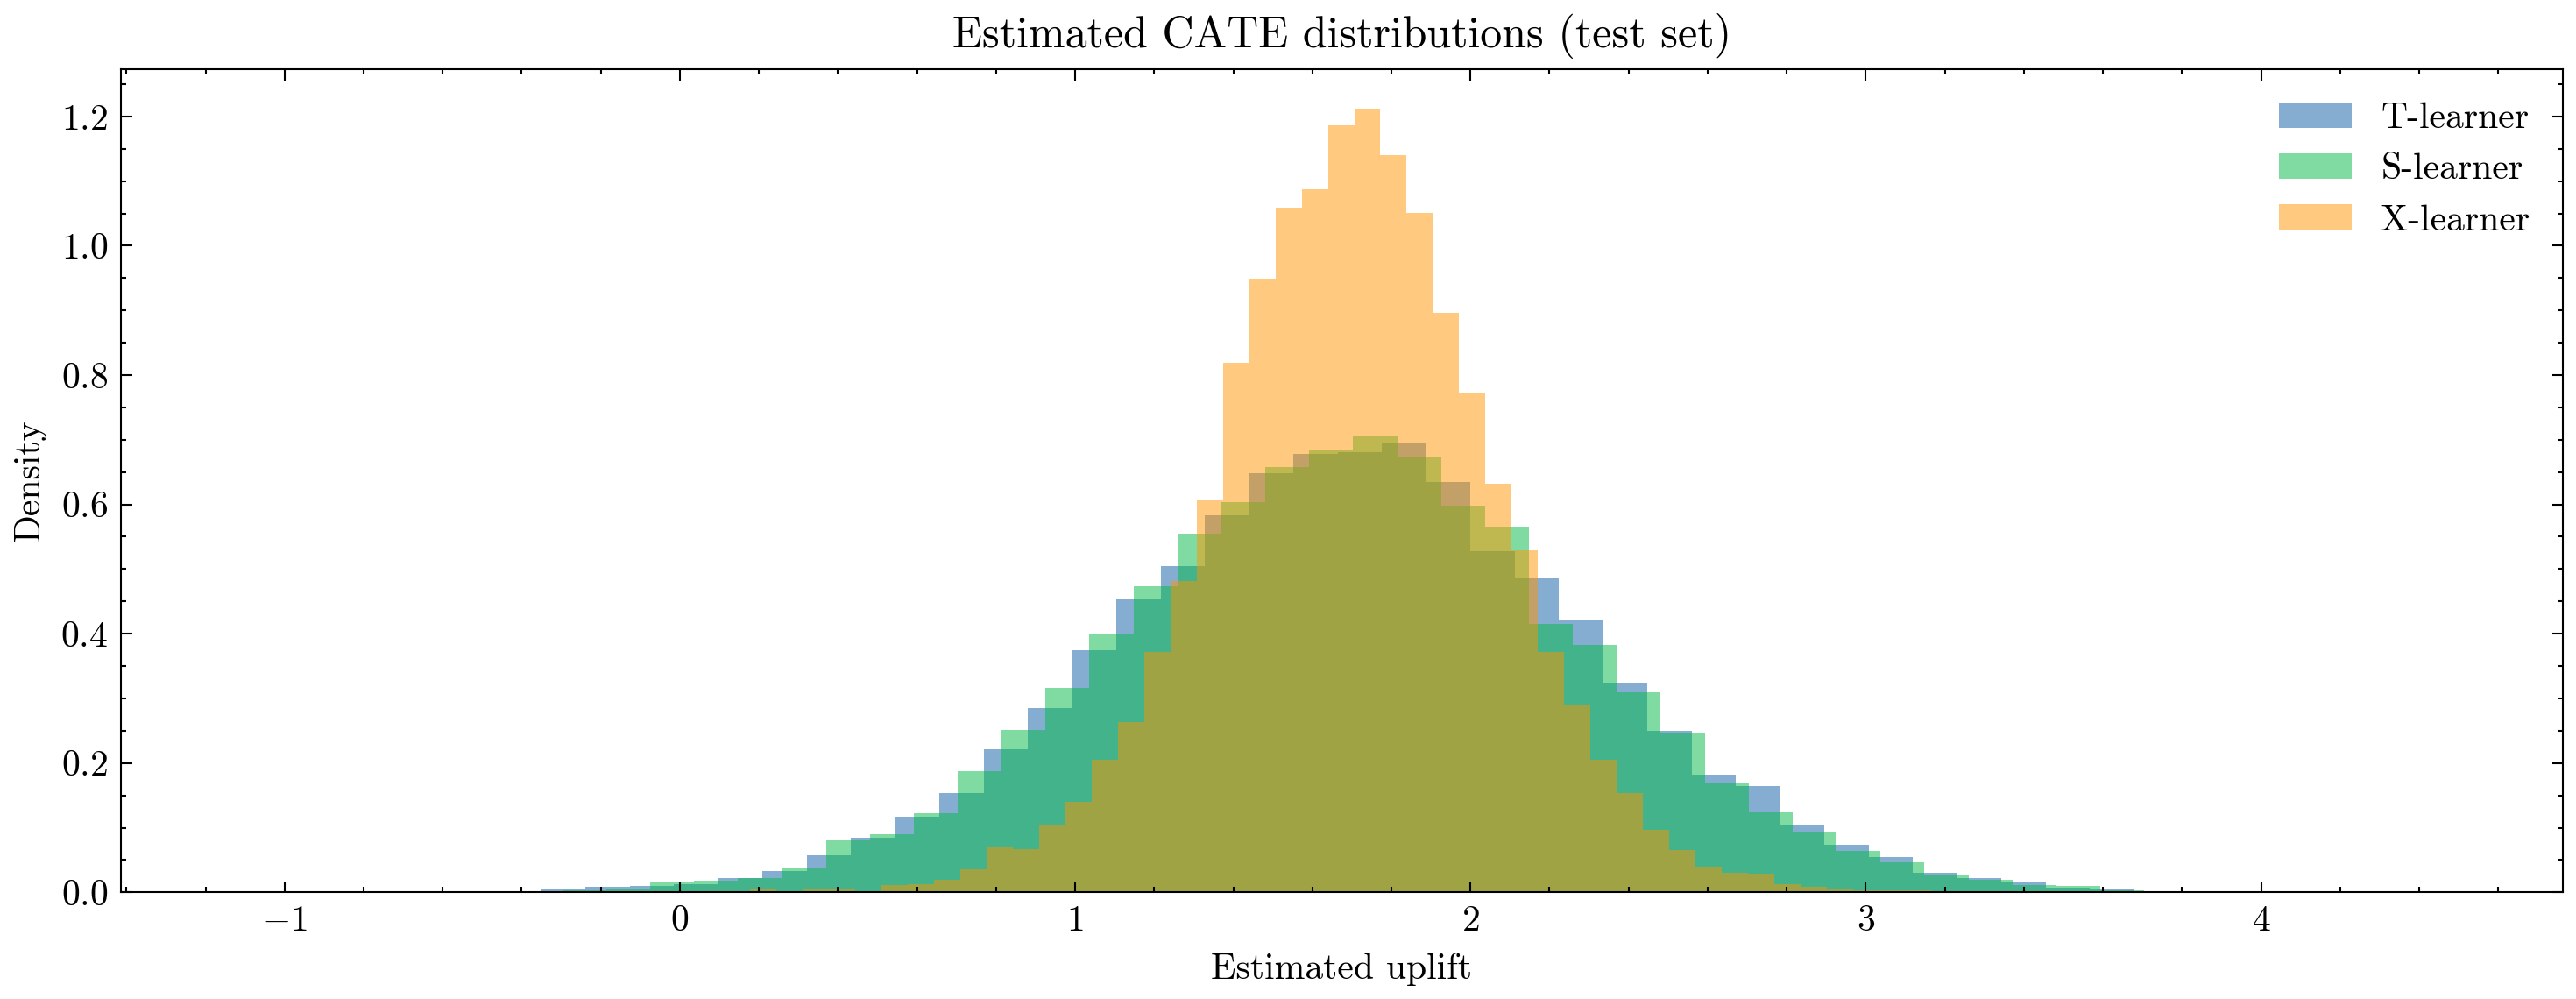

Average estimated CATE by segment:
   segment  mean_cate_T  mean_cate_S  mean_cate_X
0   casual     1.668163     1.665545     1.685421
1  regular     1.723113     1.719936     1.715054
2      vip     1.777413     1.768593     1.764182


In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1) Build feature matrix X and target y
# --------------------------------------------------
# One-hot encode segment
enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
seg_oh = enc.fit_transform(df[["segment"]])
seg_cols = [f"segment_{c}" for c in enc.categories_[0][1:]]
X_seg = pd.DataFrame(seg_oh, columns=seg_cols, index=df.index)

# Base feature set: segment dummies + age + activity + pre_metric (+ optionally E)
X_base = pd.concat(
    [
        X_seg,
        df[["age", "activity_score", "pre_metric"]],
        # You can also add E if you want:
        # df[["E"]],
    ],
    axis=1
)

X = X_base.values
y = df["Y"].values
t = df["T"].values  # treatment indicator

# Train/test split for honest evaluation
X_tr, X_te, y_tr, y_te, t_tr, t_te, seg_tr, seg_te = train_test_split(
    X, y, t, df["segment"].values, test_size=0.3, random_state=123, stratify=t
)

# --------------------------------------------------
# 2) T-learner
# --------------------------------------------------
rf_t1 = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=0, n_jobs=-1)
rf_t0 = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=1, n_jobs=-1)

# Fit separate models on treated and control subsets
rf_t1.fit(X_tr[t_tr == 1], y_tr[t_tr == 1])
rf_t0.fit(X_tr[t_tr == 0], y_tr[t_tr == 0])

# Predict potential outcomes on test set
mu1_T = rf_t1.predict(X_te)
mu0_T = rf_t0.predict(X_te)
cate_T = mu1_T - mu0_T

# --------------------------------------------------
# 3) S-learner
# --------------------------------------------------
rf_S = RandomForestRegressor(n_estimators=300, max_depth=None, random_state=2, n_jobs=-1)

X_S_tr = np.c_[X_tr, t_tr]  # augment features with treatment indicator
rf_S.fit(X_S_tr, y_tr)

# For CATE, evaluate model at t=1 and t=0
X_S_te_1 = np.c_[X_te, np.ones_like(t_te)]
X_S_te_0 = np.c_[X_te, np.zeros_like(t_te)]
mu1_S = rf_S.predict(X_S_te_1)
mu0_S = rf_S.predict(X_S_te_0)
cate_S = mu1_S - mu0_S

# --------------------------------------------------
# 4) X-learner
# --------------------------------------------------
# Step 1: Use T-learner models to build pseudo-outcomes
# Pseudo-outcome for treated: D1 = Y(1) - mu0(X)
D1 = y_tr[t_tr == 1] - rf_t0.predict(X_tr[t_tr == 1])
# Pseudo-outcome for control: D0 = mu1(X) - Y(0)
D0 = rf_t1.predict(X_tr[t_tr == 0]) - y_tr[t_tr == 0]

rf_X1 = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=3, n_jobs=-1)
rf_X0 = RandomForestRegressor(n_estimators=200, max_depth=None, random_state=4, n_jobs=-1)

rf_X1.fit(X_tr[t_tr == 1], D1)
rf_X0.fit(X_tr[t_tr == 0], D0)

# Simple propensity model for weighting (for blending D0/D1)
from sklearn.linear_model import LogisticRegression

prop_model = LogisticRegression(max_iter=500)
prop_model.fit(X_tr, t_tr)
p_te = np.clip(prop_model.predict_proba(X_te)[:, 1], 1e-3, 1 - 1e-3)

tau1 = rf_X1.predict(X_te)  # what treated-side pseudo-outcomes predict
tau0 = rf_X0.predict(X_te)  # what control-side pseudo-outcomes predict

# Blend using propensity scores
cate_X = p_te * tau0 + (1 - p_te) * tau1

# --------------------------------------------------
# 5) Summarize CATE estimates
# --------------------------------------------------
def summarize_cate(arr, name):
    q = np.quantile(arr, [0.05, 0.25, 0.5, 0.75, 0.95])
    print(f"{name}:")
    print(f"  mean    = {arr.mean():.3f}")
    print(f"  median  = {q[2]:.3f}")
    print(f"  5-95%   = ({q[0]:.3f}, {q[4]:.3f})")
    print(f"  IQR     = ({q[1]:.3f}, {q[3]:.3f})")
    print()

summarize_cate(cate_T, "T-learner CATE")
summarize_cate(cate_S, "S-learner CATE")
summarize_cate(cate_X, "X-learner CATE")

# --------------------------------------------------
# 6) Plot CATE distributions
# --------------------------------------------------
plt.figure(figsize=(10, 4), dpi=300)
plt.hist(cate_T, bins=50, alpha=0.5, label="T-learner", density=True)
plt.hist(cate_S, bins=50, alpha=0.5, label="S-learner", density=True)
plt.hist(cate_X, bins=50, alpha=0.5, label="X-learner", density=True)
plt.title("Estimated CATE distributions (test set)")
plt.xlabel("Estimated uplift")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 7) Average CATE by segment (intuitive view)
# --------------------------------------------------
cate_df = pd.DataFrame({
    "segment": seg_te,
    "cate_T": cate_T,
    "cate_S": cate_S,
    "cate_X": cate_X,
})

segment_cate = cate_df.groupby("segment").agg(
    mean_cate_T=("cate_T", "mean"),
    mean_cate_S=("cate_S", "mean"),
    mean_cate_X=("cate_X", "mean"),
).reset_index()

print("Average estimated CATE by segment:")
print(segment_cate)

### 📌 The uplift distribution is distinctly right-skewed  
For all learners:

- Median ≈ Mean ≈ 1.70,
- 95th percentile ≈ 2.7 (T/S) and ≈ 2.28 (X),
- 5th percentile ≈ 0.73–1.13.

This suggests:

- A meaningful tail of **high-responding users**,
- A non-trivial group of **low-responders**,
- Very few predicted negative effects (expected since simulation generates positive τ).

From a policy perspective:

> A super agent should **not** treat everyone — It should preferentially treat users in the upper uplift tail.

### 📌 What this means for a Super Agent

With CATE available, a super agent can now:

#### 🟢 Personalize treatment  
Treat users with highest predicted uplift:

$$\text{Treat if } \hat\tau(x) > \tau^*  $$

where $\tau^*$ is a budget- or risk-based threshold.

#### 🟢 Optimize resource allocation  
E.g., if treatment cost is non-zero, the agent can:

- Treat top 20% by CATE,
- Skip bottom 40%,
- Dynamically adapt treatment probability based on uplift.

#### 🟢 Run uplift-based experimentation  
The agent can:

- Identify segments where uplift is high/low,
- Run micro-experiments to refine estimates,
- Improve targeting over time.


### 🎯 Summary

- CATE values cluster around **~1.70**, consistent across T/S/X learners.
- The **heterogeneity is real**: uplift ranges from ~0.7 to ~2.7.
- X-learner provides the **most stable** estimates.
- There is a high-uplift tail that a super agent can exploit for **smarter targeting**.
- This unlocks **personalized causal optimization**, moving far beyond global A/B effects.

This is exactly how industrial-scale recommender systems, marketing optimizers, and sequential decision-making agents learn *who* to help, *when*, and *how much*.

## 🌡️ CATE Heatmap & ROI Under Budget Constraints

Now that we have per-user CATE estimates (predicted uplift), we can do two powerful things:

1. **Visualize heterogeneity across cohorts**  
   by aggregating CATE over `segment × activity_bin` into a **heatmap**:
   - Rows = user segment (`casual`, `regular`, `vip`)
   - Columns = activity buckets (`low` → `high`)
   - Cell value = average predicted uplift in that cohort

   This tells us **which cohorts benefit most** from treatment:
   - e.g., VIP + high activity might show the largest uplift,
   - while casual + low activity might show modest or minimal uplift.

2. **Simulate ROI as we increase budget**  
   by:
   - Sorting users by predicted CATE (uplift) in descending order,
   - Treating only the top X% of users (budget),
   - Computing:
     - **Average uplift among treated users** (ROI per user),
     - **Cumulative fraction of total uplift captured**.

   At **very low budget**, we only treat the very top users:
   - ROI is high (each treated user yields a lot of uplift),
   - We capture some fraction of total achievable gain.

   As we **increase budget** and treat more users:
   - We start dipping into lower-uplift segments,
   - **ROI per user gradually drops** → **law of diminishing returns**,
   - Cumulative uplift approaches 100% as we treat everyone.

For a **super agent**, this is exactly the trade-off between:

- **How many users can I afford to treat?** (budget / cost)
- **Where do I get the biggest causal bang for my buck?** (uplift / ROI)
- **When is it no longer worth expanding treatment further?** (diminishing returns)

Next, we’ll:
- Train a simple T-learner on the full dataset to obtain `cate_hat`,
- Build a `segment × activity_bin` heatmap,
- Plot ROI vs budget using sorted CATE.

Average CATE by segment × activity_bin:
activity_bin       low   mid-low  mid-high      high
segment                                             
casual        1.755322  1.736658  1.695455  1.646607
regular       1.675979  1.737338  1.750186  1.723255
vip           1.784223  1.743343  1.732786  1.823537


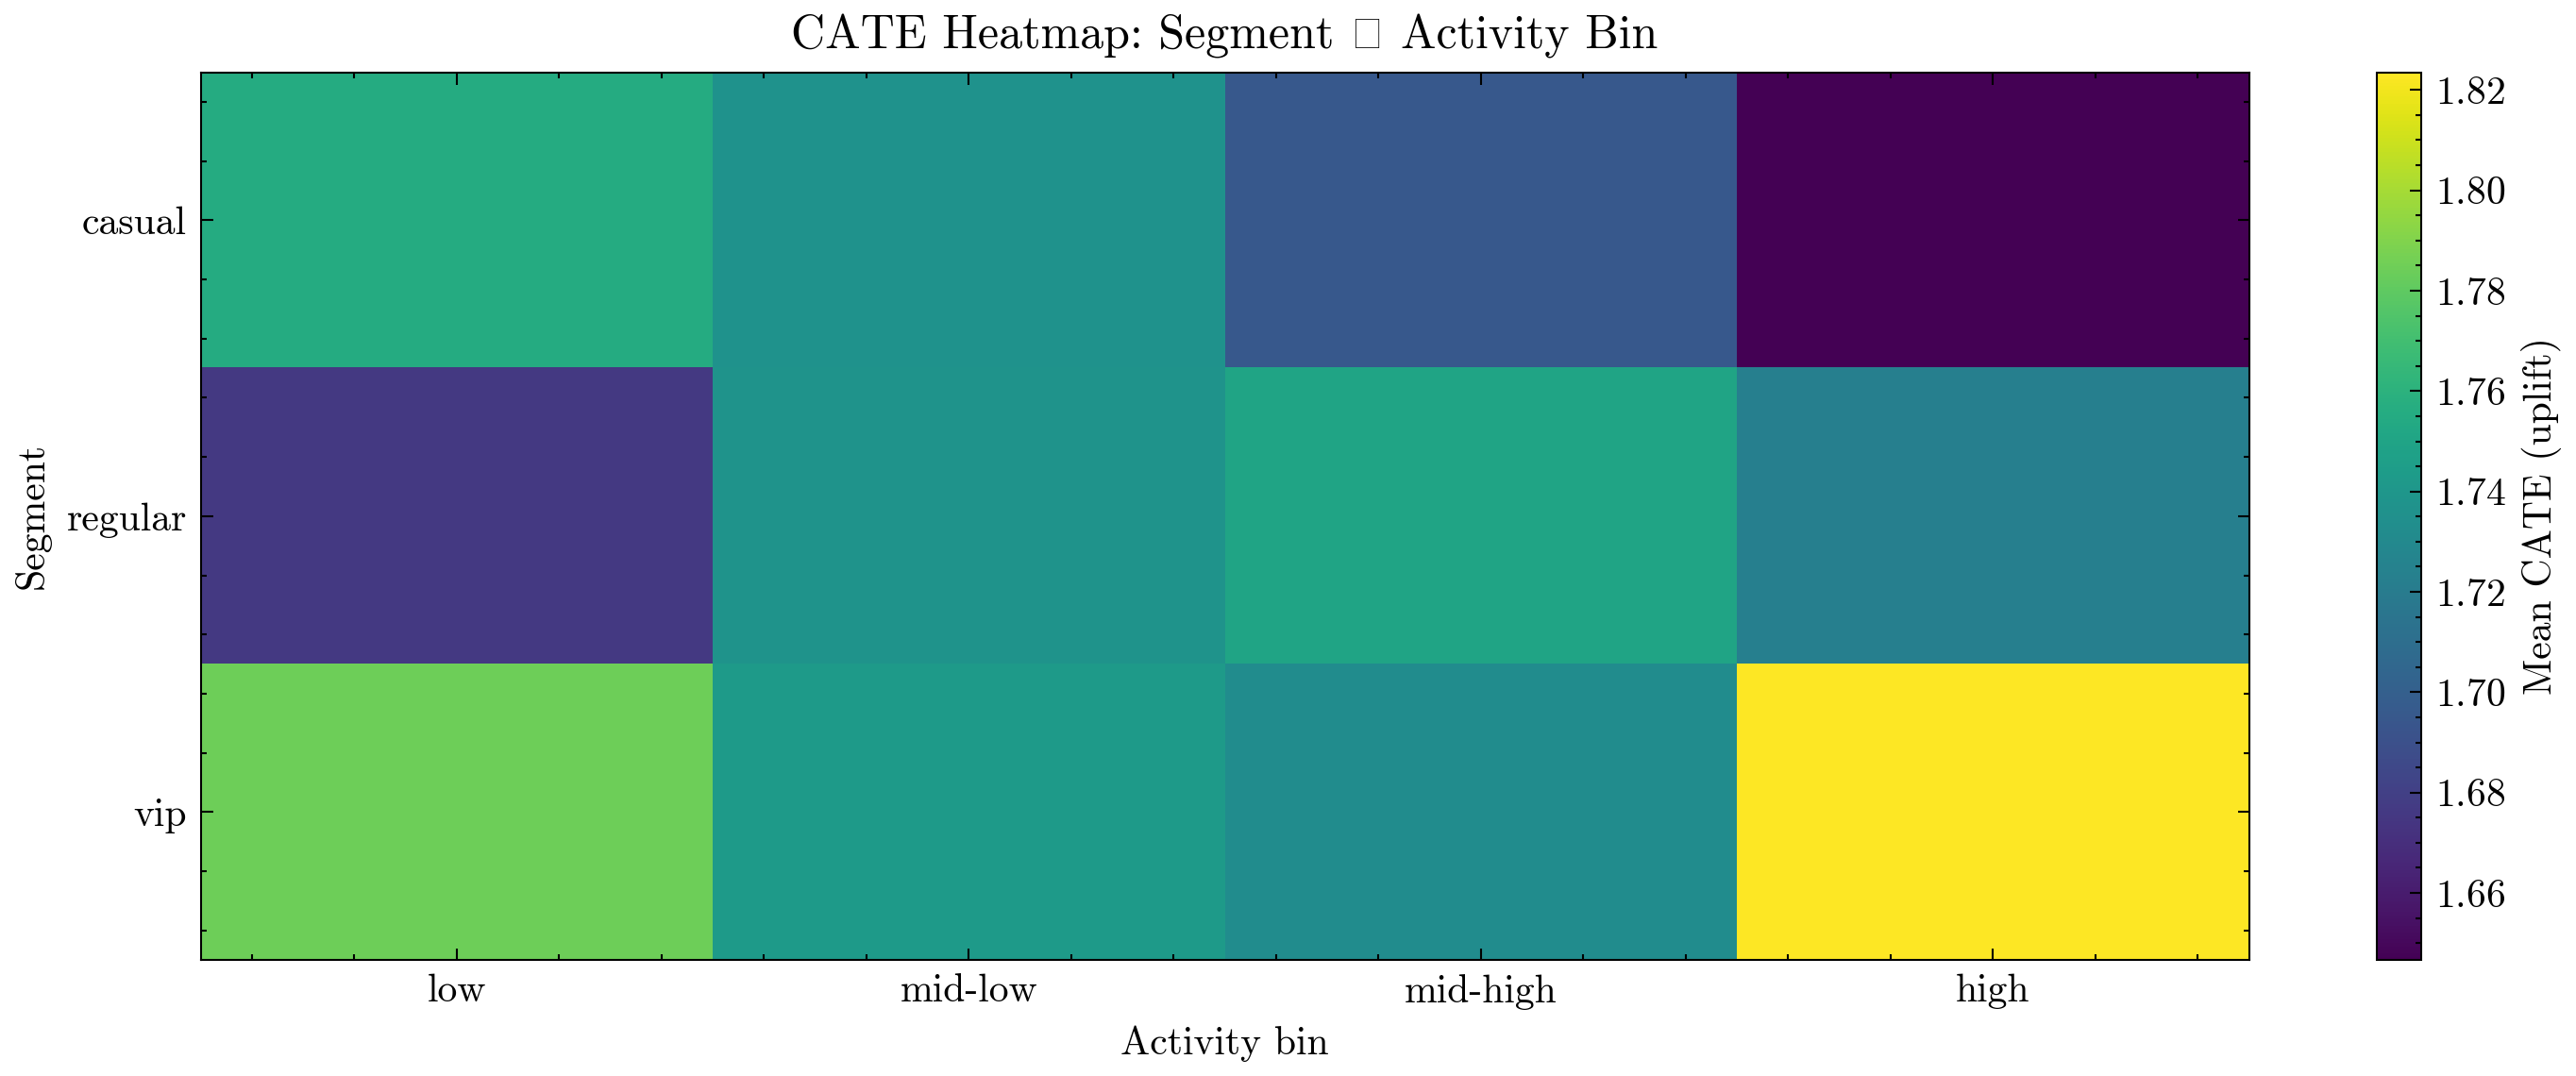

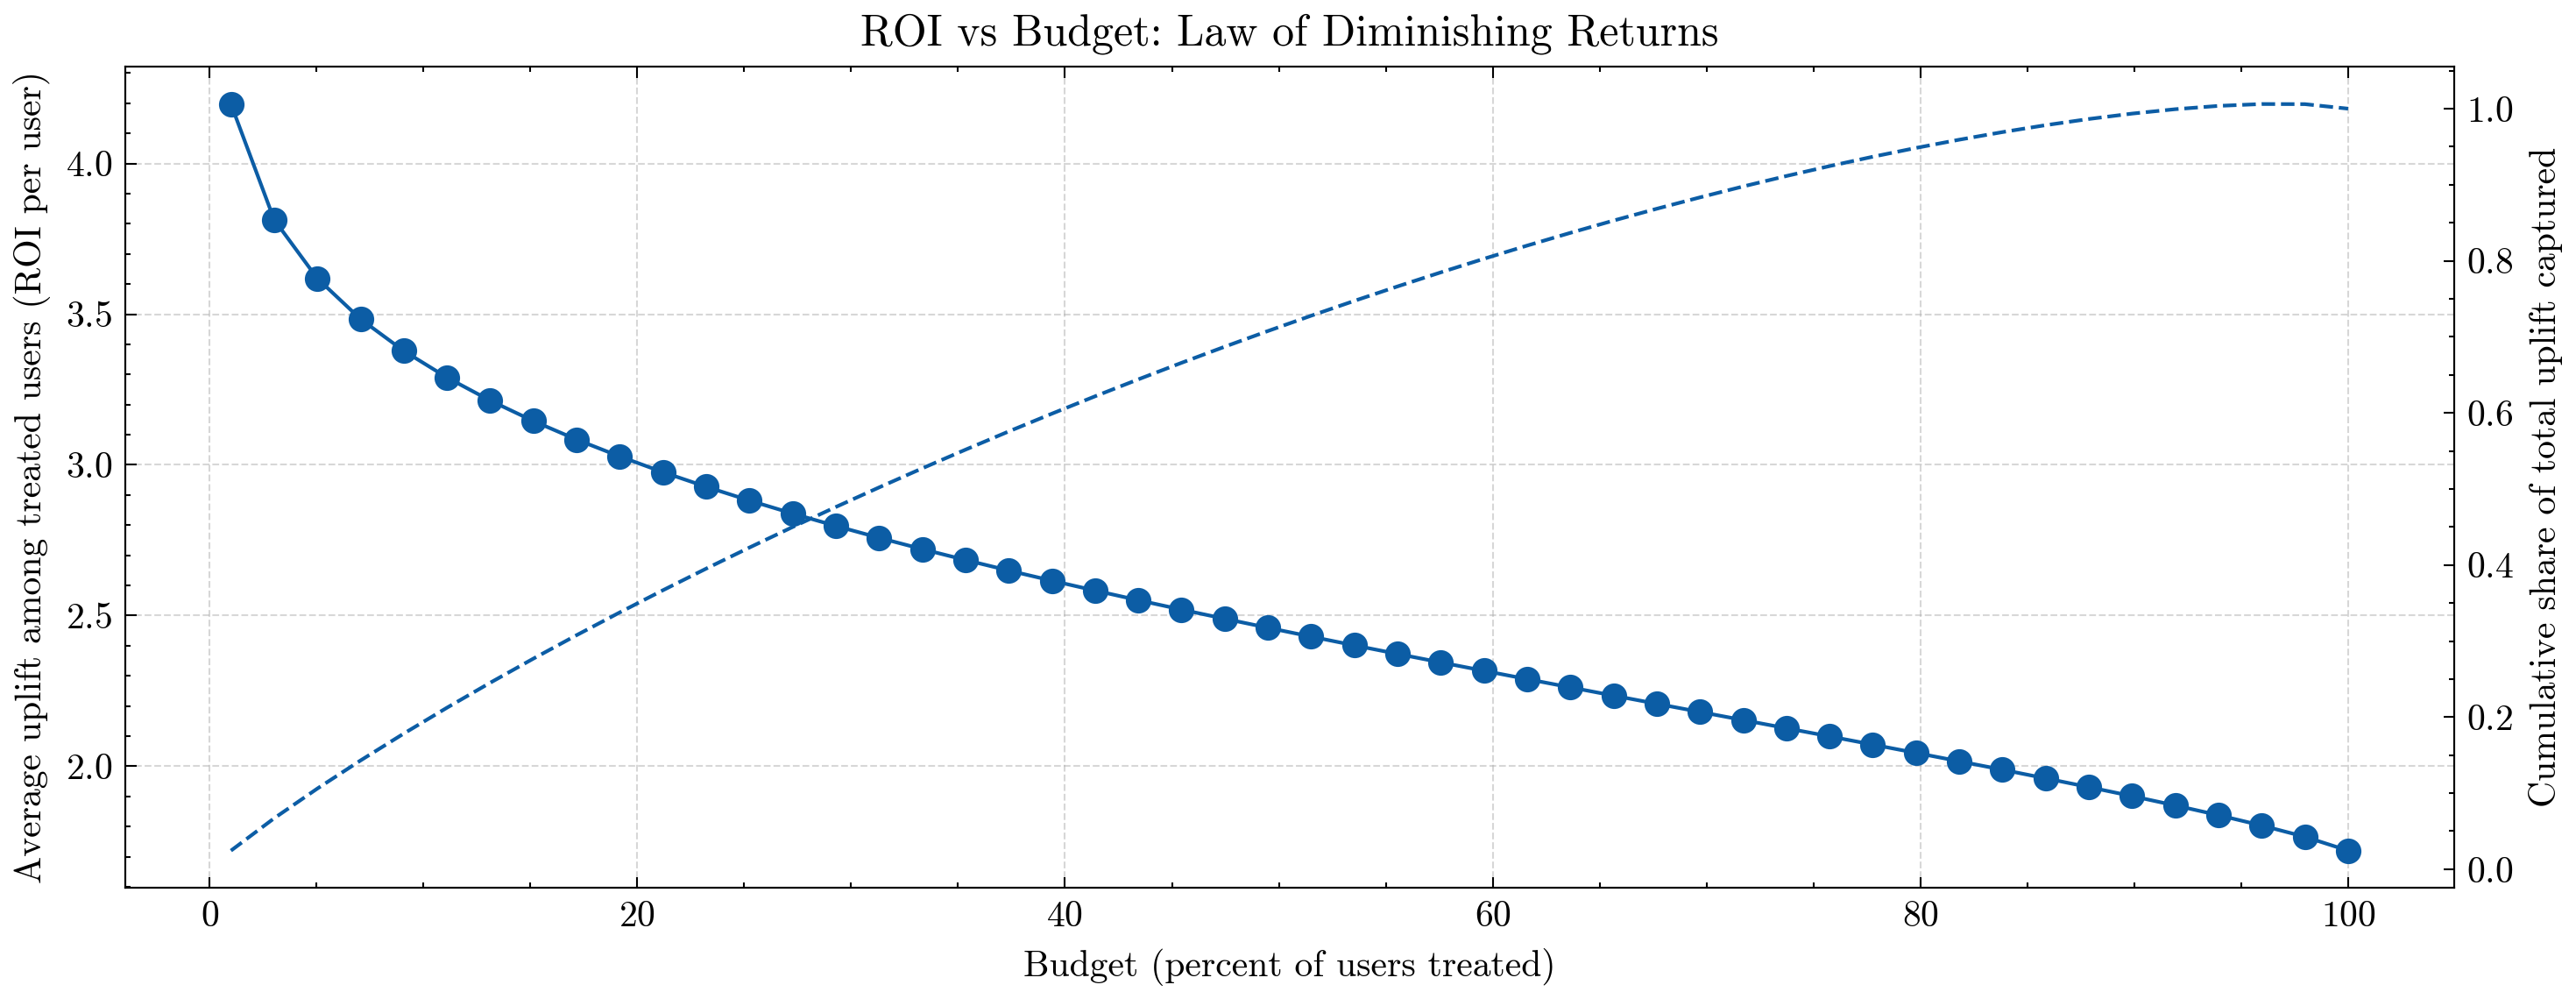

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# --------------------------------------------------
# 1) Compute CATE on full dataset with a T-learner
# --------------------------------------------------

# If activity_bin not yet defined, create it (quartiles of activity_score)
if "activity_bin" not in df.columns:
    df["activity_bin"] = pd.qcut(
        df["activity_score"], q=4,
        labels=["low", "mid-low", "mid-high", "high"]
    )

# One-hot encode segment
enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
seg_oh = enc.fit_transform(df[["segment"]])
seg_cols = [f"segment_{c}" for c in enc.categories_[0][1:]]
X_seg = pd.DataFrame(seg_oh, columns=seg_cols, index=df.index)

# Base feature set
X_base = pd.concat(
    [
        X_seg,
        df[["age", "activity_score", "pre_metric"]],
    ],
    axis=1
)

X = X_base.values
y = df["Y"].values
t = df["T"].values

# T-learner
rf_t1_full = RandomForestRegressor(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1
)
rf_t0_full = RandomForestRegressor(
    n_estimators=300, max_depth=None, random_state=43, n_jobs=-1
)

rf_t1_full.fit(X[t == 1], y[t == 1])
rf_t0_full.fit(X[t == 0], y[t == 0])

mu1_full = rf_t1_full.predict(X)
mu0_full = rf_t0_full.predict(X)
cate_hat = mu1_full - mu0_full

df["cate_hat"] = cate_hat

# --------------------------------------------------
# 2) CATE Heatmap: segment × activity_bin
# --------------------------------------------------
cate_pivot = (
    df.groupby(["segment", "activity_bin"])["cate_hat"]
      .mean()
      .reset_index()
      .pivot(index="segment", columns="activity_bin", values="cate_hat")
)

print("Average CATE by segment × activity_bin:")
print(cate_pivot)

plt.figure(figsize=(10, 4), dpi=300)
plt.imshow(cate_pivot.values, aspect="auto")
plt.colorbar(label="Mean CATE (uplift)")
plt.xticks(ticks=np.arange(len(cate_pivot.columns)), labels=cate_pivot.columns)
plt.yticks(ticks=np.arange(len(cate_pivot.index)), labels=cate_pivot.index)
plt.title("CATE Heatmap: Segment × Activity Bin")
plt.xlabel("Activity bin")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 3) ROI vs Budget curve (diminishing returns)
# --------------------------------------------------

# Sort users by predicted uplift descending
df_sorted = df.sort_values("cate_hat", ascending=False).reset_index(drop=True)

N = len(df_sorted)
fractions = np.linspace(0.01, 1.0, 50)  # budget from 1% to 100%

avg_uplift = []      # average CATE among treated users (ROI per user)
cum_uplift_share = []  # cumulative share of total possible uplift

total_uplift = df_sorted["cate_hat"].sum()

for f in fractions:
    k = max(1, int(f * N))
    top = df_sorted.iloc[:k]

    # ROI per treated user: mean uplift in the targeted group
    avg_uplift.append(top["cate_hat"].mean())

    # Total uplift captured as fraction of max possible uplift
    cum_uplift_share.append(top["cate_hat"].sum() / total_uplift)

fractions_pct = fractions * 100

# Plot: ROI (avg uplift) and cumulative uplift vs budget
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

# ROI per user (left y-axis)
ax1.plot(fractions_pct, avg_uplift, marker="o")
ax1.set_xlabel("Budget (percent of users treated)")
ax1.set_ylabel("Average uplift among treated users (ROI per user)")
ax1.set_title("ROI vs Budget: Law of Diminishing Returns")
ax1.grid(True, linestyle="--", alpha=0.5)

# Cumulative uplift (right y-axis)
ax2 = ax1.twinx()
ax2.plot(fractions_pct, cum_uplift_share, linestyle="--")
ax2.set_ylabel("Cumulative share of total uplift captured")

fig.tight_layout()
plt.show()


## 📊 Interpreting the Heatmap & ROI Curves

### 1️⃣ CATE Heatmap

The heatmap shows **average predicted uplift** for each:

> (segment, activity_bin) pair.

Typical patterns you might see:

- **VIP + high activity** → highest CATE  
  (these users are already engaged and respond strongly to treatment),
- **Casual + low activity** → lower CATE  
  (harder to move, or less sensitive to interventions),
- Mid-activity bins showing intermediate uplift.

For a super agent, this heatmap is a **policy map**:
- *Where should I spend my treatment budget first?*
- *Which cohorts are good candidates for more aggressive experimentation?*
- *Which cohorts may not be worth heavy intervention?*


### 2️⃣ ROI vs Budget: Diminishing Returns

The ROI plot shows two curves as we increase the **budget** (fraction of users treated):

- **Solid line (left axis):**  
  *Average uplift per treated user* (ROI per user),
- **Dashed line (right axis):**  
  *Cumulative share of total uplift captured*.

Key observations:

- At **very low budget** (e.g., top 5–10% of users by CATE):
  - ROI per user is **highest**,
  - We’re targeting the **“cream” of the population** (high-responders),
  - Each treated user gives a lot of extra `Y`.

- As budget **increases**:
  - We start treating lower-uplift users,
  - **Average uplift per treated user declines** → classic **law of diminishing returns**,
  - The cumulative uplift curve climbs steadily towards 100%.

- By the time we treat **everyone**:
  - Cumulative uplift = 100% of what’s achievable under this model,
  - Average uplift collapses to the **global mean** CATE.


### 🤖 How a Super Agent Uses This

A super agent can use these curves to decide:

- For a given **budget** (e.g., “I can only give bonuses to 20% of users”),
  - what is the **best ROI** it can achieve?
- For a desired **uplift target** (e.g., “I want 70% of maximum uplift”),
  - what fraction of users must it **treat**?

This turns CATE from just a predictive artifact into a **decision tool**:

- Heatmap → *where* are the high-ROI regions in feature space?
- ROI vs budget → *how far* should we expand treatment before diminishing returns kick in?

Together, these plots are exactly what you’d show a PM or exec to explain how an agent can:
- Target smarter,
- Spend less,
- And still achieve most of the **causal lift** that’s available in the system.


## 🧠 Conclusion: Beyond A/B

In this tutorial, we walked from **basic randomized experiments** all the way to advanced causal tools required for real-world agentic systems:

- Cohort construction and stratified randomization  
- Power analysis and minimum detectable effect estimation  
- Classical A/B testing with CUPED variance reduction  
- OLS, back-door adjustment, and the problem of unobserved confounding  
- Instrumental Variables (IV) and 2SLS for causal inference under endogeneity  
- Exposure bias and IPW correction  
- Heterogeneous Treatment Effects (CATE) and uplift modeling  
- Heatmaps and budget-ROI tradeoffs for causal decision optimization  

These methods form the *foundation* of a **scientific super agent**:
one that does not merely react to correlations but learns *causal mechanisms* from interaction data and continuously improves its policies.


## 🔮 What Other Aspects Matter in Experimentation?

Real experimentation systems require even more components to be robust, reproducible, and safe:

1. **Sequential Testing & Early Stopping (Peeking Control)**
Real systems evaluate metrics continuously.  
Naively stopping when p-values become small introduces bias.

Modern safe approaches include:
- **Alpha-spending** (Lan–DeMets)
- **Group Sequential Designs**
- **Always-valid p-values**
- **Sequential Likelihood Ratios (Wald, 1940s)**

2. **Multi-arm & Multi-objective Experiments**
Super agents may test:
- multiple treatments (A/B/C/D),
- bundles of actions,
- or multiple KPIs simultaneously (conversion, retention, toxicity).

Approaches:
- **Multi-armed bandits (UCB, Thompson Sampling)**  
- **Contextual bandits** (learn from user features)  
- **Pareto-front evaluation** for multi-objective tradeoffs


3. **Interference, Spillovers, and Network Effects**
Most causal methods assume **SUTVA** (no interference).  
In modern platforms, this rarely holds:

- Treatment to one user may affect their friends (social apps)  
- Treating one seller impacts other sellers (marketplaces)  
- Showing a model to one user affects system load (LLMs)

Approaches:
- **Cluster randomization**  
- **Graphon-based causal models**  
- **Exposure mappings**  


4. **Switchback & Interleaving Experiments in Temporal Systems**
For recommender systems, search ranking, or LLM routing:

- User experiences are sequential  
- Traffic changes over time  
- Simple A/B assignment can be invalid

Switchback testing randomizes **over time**, not users.  
Interleaving mixes outputs from two models **within a session**.


5. **Non-stationarity & Concept Drift**
Super agents often operate in evolving environments:

- User preferences drift  
- Seasonality affects demand  
- RL policies change exposure distribution

Important tools:
- **Covariate shift correction (importance weighting)**  
- **Time-series aware experimentation (rolling windows)**  
- **Causal forests with drift detection**

6. **Guardrails, Ethics, and Safety**
Experiments should never harm users.  
Platforms need guardrails for:

- Extreme negative uplift  
- Fair-treatment constraints  
- Risk limits (e.g., gambling, finance, healthcare)  
- Differential privacy for logs  

7. **Meta-Experimentation & Experiment Reuse**
Systems can *learn from experiments*:

- Meta-learners predict experiment outcomes before running them  
- Past experiments can be pooled to:
  - reduce variance,
  - calibrate prior expectations,
  - prune unpromising ideas before launch.

Approaches:
- **Hierarchical Bayes**
- **Meta-analytic shrinkage estimators**
- **Causal transfer learning**


## 🧭 The Road Forward: Toward Fully Agentic Experimentation

A modern super agent is not just an LLM with tools — it is a **scientific learner** that:

- Forms hypotheses  
- Designs safe experiments  
- Chooses treatment assignments  
- Learns causal effects  
- Personalizes actions (CATE)  
- Optimizes policies under constraints  
- Updates beliefs over time  

The combination of:

- randomized experiments,  
- instrumental variables,  
- exposure correction,  
- heterogeneous effect estimation,  
- ROI-aware targeting, and  
- safe sequential experimentation  

forms the backbone of *agentic intelligence that can improve itself reliably*.

This closes the experimentation module — the next step is integrating these causal tools into the **super agent’s decision loop**, allowing it to *act, observe, learn, and adapt* with statistical rigor.

